In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys, os, time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR']bb, 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


Cannot import mxnet.
Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/

In [2]:
scan_parameters = {}
scan_parameters['stack'] = 'MD589'
scan_parameters['patch_size'] = 448
scan_parameters['patch_half_size'] = scan_parameters['patch_size']/2
scan_parameters['stride'] = 112

scan_parameters['section_limits'] = metadata_cache['section_limits'][scan_parameters['stack']]
scan_parameters['o_crop'] = True
scan_parameters['o_clear_border'] = True
scan_parameters['o_relabel'] = True
scan_parameters['oriImL1'], scan_parameters['oriImL0'] = metadata_cache['image_shape'][scan_parameters['stack']]
scan_parameters['scan_section_range'] = 1

scan_parameters['prop'] = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter','perimeter','compactness']
scan_parameters['prop_for_comparison'] = ['area', 'compactness']
scan_parameters['compare_weight'] = [1 for i in range(len(scan_parameters['prop_for_comparison']))]
# scan_parameters['compare_weight'] = [1 for i in range(len(scan_parameters['prop_for_comparison']) + 6)]
scan_parameters['compare_weight'] = np.array(scan_parameters['compare_weight'])/ float(np.sum(scan_parameters['compare_weight']))
scan_parameters['similarity_threshold'] = 0.8
scan_parameters['o_fix_scan_size'] = True
scan_parameters['scan_size'] = 112
scan_parameters['scan_size_coeff'] = 5
scan_parameters['builtInProps'] = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter']

scan_parameters['prop_to_save'] = ['coords','moments_hu','centroid','area','eccentricity','equivalent_diameter']

stack = scan_parameters['stack']

In [3]:
contour_df = DataManager.load_annotation_v4(stack=scan_parameters['stack'],by_human=True,suffix='contours',timestamp='latest')
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour_df,stack=stack)
structure_name = '7N'
vertice_7N_dic = {record['section']:np.array(record['vertices'],np.int) for _, record in contour_df[contour_df['name']==structure_name].iterrows()}
sectionList_7N = np.sort(vertice_7N_dic.keys())

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/shared/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  07292017045157


In [6]:
DataManager.load_image_v2(stack=stack, section=152, version='jpeg', prep_id=2)

/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (185246720 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


array([[[209, 218, 233],
        [207, 216, 231],
        [208, 217, 232],
        ..., 
        [222, 230, 233],
        [226, 233, 239],
        [226, 233, 239]],

       [[205, 214, 229],
        [204, 213, 228],
        [206, 215, 230],
        ..., 
        [222, 230, 233],
        [227, 234, 240],
        [227, 234, 240]],

       [[205, 214, 229],
        [205, 214, 229],
        [206, 215, 230],
        ..., 
        [223, 231, 234],
        [227, 234, 240],
        [228, 235, 241]],

       ..., 
       [[227, 232, 236],
        [228, 233, 237],
        [228, 233, 237],
        ..., 
        [231, 239, 242],
        [232, 240, 243],
        [231, 239, 242]],

       [[229, 234, 238],
        [229, 234, 238],
        [229, 234, 238],
        ..., 
        [234, 242, 245],
        [236, 244, 247],
        [235, 243, 246]],

       [[231, 236, 240],
        [231, 236, 240],
        [230, 235, 239],
        ..., 
        [237, 245, 248],
        [238, 246, 249],
        [237, 245,

In [4]:
# loading data
image = {}
stack = scan_parameters['stack']
section_begin, section_end = scan_parameters['section_limits']
# secList = range(section_begin, section_end+1)
# tempSecList = range(section_begin, section_end+1)
secList = list(sectionList_7N[0:10])
tempSecList = list(sectionList_7N[0:10])
# for tempSec in tempSecList:
#     try:
#         image[tempSec] = fun_crop_images(DataManager.load_image_v2(stack=stack, section=tempSec, version='jpeg', prep_id=2),*scan_parameters['crop_range_mmxx'],im0max=scan_parameters['oriImL0'],im1max=scan_parameters['oriImL1'] )
#     except:
#         sys.stderr.write('Invalid section %d...\n'%tempSec)
#         secList.remove(tempSec)
#         continue
# #     if os.path.isfile(img_filename[tempSec]):
# #         sys.stderr.write('Image file is already available. \n')
# #         continue
# #     else:
# #         try:
# #             download_from_s3(img_filename[tempSec])
# #         except:
# #             sys.stderr.write('Download fail. Skip this file for section %d...\n'%tempSec)
# #             secList.remove(tempSec)
# #             continue   
# scan_parameters['secList'] = secList

In [88]:
margin = 10
bboxs_7N = {sec:fun_polygon_bbox(vertice_7N_dic[sec]) for sec in sectionList_7N}
bbox_7N = fun_polygons_bbox(bboxs_7N.values(),margin=margin)
scan_parameters['crop_range_mmxx'] = bbox_7N
scan_parameters['crop_0_min'], scan_parameters['crop_1_min'],scan_parameters['crop_0_max'],scan_parameters['crop_1_max'] = bbox_7N 
scan_parameters['im0max'] = scan_parameters['crop_0_max'] - scan_parameters['crop_0_min']
scan_parameters['im1max'] = scan_parameters['crop_1_max'] - scan_parameters['crop_1_min']
scan_parameters['crop_range_mxmx'] = fun_mmxx_to_mxmx(*scan_parameters['crop_range_mxmx'])

KeyError: 'crop_range_mxmx'

In [48]:
sec = 153
scan_section_range = 1
sec_load_data_list = range(sec - scan_section_range, sec + scan_section_range + 1)
scan_section = list(sec_load_data_list)
scan_section.remove(sec)
secList = scan_parameters['secList']
stack = scan_parameters['stack']

In [49]:
cell_centroids = {}
cell_numbers = {}
cell_global_coord = {}
im_blob_prop = {}
im_label_ori = {}
im_label = {}
im_BW = {}
for tempSec in sec_load_data_list:
    if tempSec in secList:
        cell_global_coord[tempSec] = load_cell_data('coords', stack=stack, sec=tempSec)
        temp_im_label, temp_im_blob_prop, _ = fun_reconstruct_labeled_image(cell_global_coord[tempSec],crop_range= scan_parameters['crop_range_mxmx'], 
                                                                    oriImL0=scan_parameters['oriImL0'],oriImL1=scan_parameters['oriImL1'])
        im_label[tempSec] = temp_im_label
        im_BW[tempSec] = temp_im_label > 0
        im_blob_prop[tempSec] = np.array(temp_im_blob_prop)
    else:
        sys.stderr.write('Warning: missing section %d'%tempSec)
        scan_section.remove(tempSec)
n_blobs = {tempSec: len(im_blob_prop[tempSec]) for tempSec in im_blob_prop.keys()}


rm -rf "/shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_blobCoords.hdf" && mkdir -p "/shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079"
aws s3 cp "s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_blobCoords.hdf" "/shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_blobCoords.hdf"


In [87]:
typical_blobs = []
matched_paris = []
scan_range = scan_parameters['scan_section_range']
scan_section = range(section - scan_range, section + scan_range + 1)
scan_section.remove(section)
im0max = scan_parameters['im0max']
im1max = scan_parameters['im1max']

prop = scan_parameters['prop']
prop_for_comparison = scan_parameters['prop_for_comparison']

compare_weight = scan_parameters['compare_weight']
o_simil_threshold = scan_parameters['similarity_threshold']

o_fix_scan_size = scan_parameters['o_fix_scan_size']
o_scan_size_coeff = scan_parameters['scan_size_coeff']
o_scan_size = scan_parameters['scan_size']  
secList_in_BlobPropDic = im_blob_prop.keys()
n_blobs = {}
blobs_idx_dic = {}
blobs_centroids_dic = {}
for tempSec in secList_in_BlobPropDic:
    n_blobs[tempSec] = len(im_blob_prop[tempSec])
    blobs_idx_dic[tempSec] = np.arange(0, n_blobs[tempSec], dtype=np.int32)
    blobs_centroids_dic[tempSec] = np.array([im_blob_prop[tempSec][tempBID]['centroid'] for tempBID in blobs_idx_dic[tempSec]])

KeyError: 'im0max'

In [86]:
if set(scan_section).issubset(set(secList_in_BlobPropDic)):
    pass
else:
    print('Warrning: Scaned section(s) not included in input im_blob_prop')

for blobID in range(n_blobs[section]):
    if (blobID % 1000 == 0):
        print('Section %d Finished percentage: %f'%(section, (float(blobID)*100 / n_blobs[section]) ))
    
    temp_curr_blob_props = {}
    for tempProp in prop:
        if tempProp in scan_parameters['builtInProps']:
            temp_curr_blob_props[tempProp] = im_blob_prop[section][blobID][tempProp]
        elif tempProp == 'compactness':
            temp_curr_blob_props[tempProp] = im_blob_prop[section][blobID]['perimeter']**2/(4*PI*im_blob_prop[section][blobID]['area'])

    if temp_curr_blob_props['area']<100 or temp_curr_blob_props['compactness'] > 2.5 or temp_curr_blob_props['area']>3000:
        print('Blob %d eliminated'%blobID)
        continue
    
    
    
    tempB1_idx_loc = temp_curr_blob_props['centroid']
    if o_fix_scan_size:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max)
    else:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max)


    for tempSec in scan_section:
        print('Blbo %d left. Start scanning'%blobID)
        if tempSec not in secList_in_BlobPropDic:
            continue

        # Find blobs at the nearby location in the scaned section
        # Method 1
        tempPath = matplotlib.path.Path(temp_next_sec_range)
        tempBlobInside = tempPath.contains_points(blobs_centroids_dic[tempSec])
        tempBlobInsideIndex = blobs_idx_dic[tempSec][tempBlobInside]            
        # Method 2
#            temp_im = fun_crop_images(im_label[tempSec],*temp_next_sec_range_1D, margin=0,im0max=im0max, im1max=im1max)
#            tempBlobInsideIndex = np.delete(np.unique(temp_im.flatten()),0,axis=0) - 1           
        temp_num_blob = len(tempBlobInsideIndex)
        if temp_num_blob:
            temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
        else:
#             print('No blobs found in this section')
            continue

        # Get blob properties
        temp_next_blob_props = {}
        for tempProp in prop:
            temp_prop_value = []
            if tempProp=='relative_dict':
                for blobIndex in range(temp_num_blob):
                    temp_prop_value.append(fun_local_distance(temp_next_sec_blob_prop[blobIndex]['centroid'],local_cloc))
            elif tempProp in scan_parameters['builtInProps']:
                for blobIndex in range(temp_num_blob):
                    temp_prop_value.append(temp_next_sec_blob_prop[blobIndex][tempProp])
            elif tempProp=='compactness':
                for blobIndex in range(temp_num_blob):
                    temp_prop_value.append(temp_next_sec_blob_prop[blobIndex]['perimeter']**2 /
                                       temp_next_sec_blob_prop[blobIndex]['area'] / (4*PI))
            temp_next_blob_props[tempProp] = temp_prop_value

        #### Construct similarity matrix ####
        temp_sim = {}
        for temp_prop in prop_for_comparison:
                temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                         temp_next_blob_props[temp_prop],distance_type=temp_prop))
        temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))

        #### Blob comparison ####
        temp_weighted_sim = np.dot(temp_sim_matrix,compare_weight)
        temp_compare_result = temp_weighted_sim > o_simil_threshold
        print('Typical blob found: Blob %d similarity %f'%(blobID,max(temp_weighted_sim)))
        if any(temp_compare_result.tolist()):
            print('Blob ID %d'%blobID)
            typical_blobs.append([section, blobID, im_blob_prop[section][blobID]])
            matched_paris.append([section,blobID,im_blob_prop[section][blobID],tempSec, tempBlobInsideIndex[temp_compare_result], im_blob_prop[tempSec][tempBlobInsideIndex[temp_compare_result]],temp_sim_matrix[temp_compare_result,:]])

Section 153 Finished percentage: 0.000000
Blob 0 eliminated
Blbo 1 left. Start scanning
Typical blob found: Blob 1 similarity 0.992762
Blob ID 1
Blbo 1 left. Start scanning
Typical blob found: Blob 1 similarity 0.883171
Blob ID 1
Blbo 2 left. Start scanning
Typical blob found: Blob 2 similarity 0.924803
Blob ID 2
Blbo 2 left. Start scanning
Typical blob found: Blob 2 similarity 0.922573
Blob ID 2
Blbo 3 left. Start scanning
Typical blob found: Blob 3 similarity 0.950275
Blob ID 3
Blbo 3 left. Start scanning
Typical blob found: Blob 3 similarity 0.874276
Blob ID 3
Blob 4 eliminated
Blob 5 eliminated
Blob 6 eliminated
Blob 7 eliminated
Blbo 8 left. Start scanning
Typical blob found: Blob 8 similarity 0.916727
Blob ID 8
Blbo 8 left. Start scanning
Typical blob found: Blob 8 similarity 0.784170
Blob 9 eliminated
Blbo 10 left. Start scanning
Typical blob found: Blob 10 similarity 0.763681
Blbo 10 left. Start scanning
Typical blob found: Blob 10 similarity 0.796155
Blob 11 eliminated
Blob 12

Typical blob found: Blob 129 similarity 0.688612
Blbo 129 left. Start scanning
Typical blob found: Blob 129 similarity 0.810215
Blob ID 129
Blbo 130 left. Start scanning
Typical blob found: Blob 130 similarity 0.935822
Blob ID 130
Blbo 130 left. Start scanning
Typical blob found: Blob 130 similarity 0.928781
Blob ID 130
Blbo 131 left. Start scanning
Typical blob found: Blob 131 similarity 0.801938
Blob ID 131
Blbo 131 left. Start scanning
Typical blob found: Blob 131 similarity 0.879988
Blob ID 131
Blob 132 eliminated
Blob 133 eliminated
Blob 134 eliminated
Blob 135 eliminated
Blob 136 eliminated
Blob 137 eliminated
Blob 138 eliminated
Blob 139 eliminated
Blob 140 eliminated
Blob 141 eliminated
Blob 142 eliminated
Blob 143 eliminated
Blob 144 eliminated
Blob 145 eliminated
Blob 146 eliminated
Blob 147 eliminated
Blob 148 eliminated
Blob 149 eliminated
Blob 150 eliminated
Blbo 151 left. Start scanning
Typical blob found: Blob 151 similarity 0.961686
Blob ID 151
Blbo 151 left. Start scan

Typical blob found: Blob 301 similarity 0.938305
Blob ID 301
Blbo 302 left. Start scanning
Typical blob found: Blob 302 similarity 0.815746
Blob ID 302
Blbo 302 left. Start scanning
Typical blob found: Blob 302 similarity 0.857088
Blob ID 302
Blob 303 eliminated
Blob 304 eliminated
Blbo 305 left. Start scanning
Typical blob found: Blob 305 similarity 0.937330
Blob ID 305
Blbo 305 left. Start scanning
Typical blob found: Blob 305 similarity 0.851213
Blob ID 305
Blob 306 eliminated
Blob 307 eliminated
Blbo 308 left. Start scanning
Typical blob found: Blob 308 similarity 0.882472
Blob ID 308
Blbo 308 left. Start scanning
Typical blob found: Blob 308 similarity 0.811327
Blob ID 308
Blob 309 eliminated
Blob 310 eliminated
Blob 311 eliminated
Blob 312 eliminated
Blbo 313 left. Start scanning
Typical blob found: Blob 313 similarity 0.788046
Blbo 313 left. Start scanning
Typical blob found: Blob 313 similarity 0.781796
Blob 314 eliminated
Blob 315 eliminated
Blbo 316 left. Start scanning
Typic

Typical blob found: Blob 491 similarity 0.886689
Blob ID 491
Blob 492 eliminated
Blob 493 eliminated
Blob 494 eliminated
Blob 495 eliminated
Blob 496 eliminated
Blob 497 eliminated
Blob 498 eliminated
Blbo 499 left. Start scanning
Typical blob found: Blob 499 similarity 0.676165
Blbo 499 left. Start scanning
Typical blob found: Blob 499 similarity 0.866702
Blob ID 499
Blob 500 eliminated
Blob 501 eliminated
Blob 502 eliminated
Blob 503 eliminated
Blob 504 eliminated
Blob 505 eliminated
Blob 506 eliminated
Blob 507 eliminated
Blob 508 eliminated
Blob 509 eliminated
Blbo 510 left. Start scanning
Typical blob found: Blob 510 similarity 0.646245
Blbo 510 left. Start scanning
Typical blob found: Blob 510 similarity 0.881234
Blob ID 510
Blob 511 eliminated
Blob 512 eliminated
Blob 513 eliminated
Blob 514 eliminated
Blob 515 eliminated
Blob 516 eliminated
Blbo 517 left. Start scanning
Typical blob found: Blob 517 similarity 0.872230
Blob ID 517
Blbo 517 left. Start scanning
Typical blob found

Blob 792 eliminated
Blob 793 eliminated
Blob 794 eliminated
Blob 795 eliminated
Blob 796 eliminated
Blob 797 eliminated
Blob 798 eliminated
Blob 799 eliminated
Blob 800 eliminated
Blob 801 eliminated
Blob 802 eliminated
Blob 803 eliminated
Blob 804 eliminated
Blob 805 eliminated
Blob 806 eliminated
Blob 807 eliminated
Blob 808 eliminated
Blob 809 eliminated
Blob 810 eliminated
Blob 811 eliminated
Blob 812 eliminated
Blob 813 eliminated
Blob 814 eliminated
Blob 815 eliminated
Blob 816 eliminated
Blob 817 eliminated
Blbo 818 left. Start scanning
Typical blob found: Blob 818 similarity 0.643317
Blbo 818 left. Start scanning
Typical blob found: Blob 818 similarity 0.746573
Blob 819 eliminated
Blob 820 eliminated
Blbo 821 left. Start scanning
Typical blob found: Blob 821 similarity 0.824881
Blob ID 821
Blbo 821 left. Start scanning
Typical blob found: Blob 821 similarity 0.550437
Blbo 822 left. Start scanning
Typical blob found: Blob 822 similarity 0.746080
Blbo 822 left. Start scanning
Typ

In [85]:
any(temp_compare_result.tolist())

False

In [73]:
matched_paris

[[153,
  0,
  152,
  array([ 5, 23, 49, 81], dtype=int32),
  array([<skimage.measure._regionprops._RegionProperties object at 0x7f877f229d10>,
         <skimage.measure._regionprops._RegionProperties object at 0x7f877f2aa910>], dtype=object),
  array([[ 0.85964912,  0.78289944],
         [ 0.95      ,  0.7089763 ],
         [ 0.9047619 ,  0.71140458],
         [ 0.70175439,  0.99145077]])],
 [153,
  0,
  154,
  array([26, 66], dtype=int32),
  array([<skimage.measure._regionprops._RegionProperties object at 0x7f8775e63710>,
         <skimage.measure._regionprops._RegionProperties object at 0x7f8780b16150>], dtype=object),
  array([[ 0.98245614,  0.80033016],
         [ 0.86363636,  0.96727618]])],
 [153,
  1,
  152,
  array([42], dtype=int32),
  array([<skimage.measure._regionprops._RegionProperties object at 0x7f877f23ad90>], dtype=object),
  array([[ 0.9858156,  0.9997082]])],
 [153,
  1,
  154,
  array([31], dtype=int32),
  array([<skimage.measure._regionprops._RegionProperties objec

In [83]:
typical_blobs

[[153, 0, <skimage.measure._regionprops._RegionProperties at 0x7f87ba818950>],
 [153, 0, <skimage.measure._regionprops._RegionProperties at 0x7f87ba818950>],
 [153, 1, <skimage.measure._regionprops._RegionProperties at 0x7f87766b2650>],
 [153, 1, <skimage.measure._regionprops._RegionProperties at 0x7f87766b2650>],
 [153, 2, <skimage.measure._regionprops._RegionProperties at 0x7f87766b2550>],
 [153, 2, <skimage.measure._regionprops._RegionProperties at 0x7f87766b2550>],
 [153, 3, <skimage.measure._regionprops._RegionProperties at 0x7f87766b2590>],
 [153, 3, <skimage.measure._regionprops._RegionProperties at 0x7f87766b2590>],
 [153, 4, <skimage.measure._regionprops._RegionProperties at 0x7f87766b24d0>],
 [153, 4, <skimage.measure._regionprops._RegionProperties at 0x7f87766b24d0>],
 [153, 6, <skimage.measure._regionprops._RegionProperties at 0x7f87766b2510>],
 [153, 7, <skimage.measure._regionprops._RegionProperties at 0x7f87766b2690>],
 [153, 8, <skimage.measure._regionprops._RegionPrope

### Load and crop origninal images

In [3]:
# Set examine section number range and download from S3 if not available
section_begin = 152
section_end = 154
img_filename = {}
cell_centroids = {}
cell_numbers = {}
cell_global_coord = {}
secList = range(section_begin, section_end +1 )

for tempSec in secList:
    img_filename[tempSec] = DataManager.get_image_filepath(stack=stack, section=tempSec, resol='lossless', version='cropped')
    cell_centroids[tempSec] = load_cell_data('centroid',stack=stack,sec=tempSec)
    cell_numbers[tempSec] = cell_centroids[tempSec].shape[0]
    cell_global_coord[tempSec] = load_cell_data('coords', stack=stack, sec=tempSec)
    if os.path.isfile(img_filename[tempSec]):
        sys.stderr.write('Image file is already available. \n')
        continue
    else:
        try:
            download_from_s3(img_filename[tempSec])
        except:
            sys.stderr.write('Download fail. Skip this file...\n')
            secList.remove(tempSec)
            continue           
            
# Load image, change RGB images to grayscale image, rescale the grayscale
option_rescale_grayscale = True
option_inverse_color = False
sec = section_begin + 1

im_cropped = {}
im_rescale = {}
for tempSec in secList:
    im_cropped[tempSec] = img_as_ubyte(rgb2gray(imread(img_filename[tempSec])[crop_0_min:crop_0_max,crop_1_min:crop_1_max]))
    if option_rescale_grayscale:
        im_rescale[tempSec] = fun_rescale_grayscale_image(im_cropped[tempSec],invcol=option_inverse_color)
        del im_cropped[tempSec]



Image file is already available. 
Image file is already available. 
Image file is already available. 
/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


### Show the entire image and the cropped mage

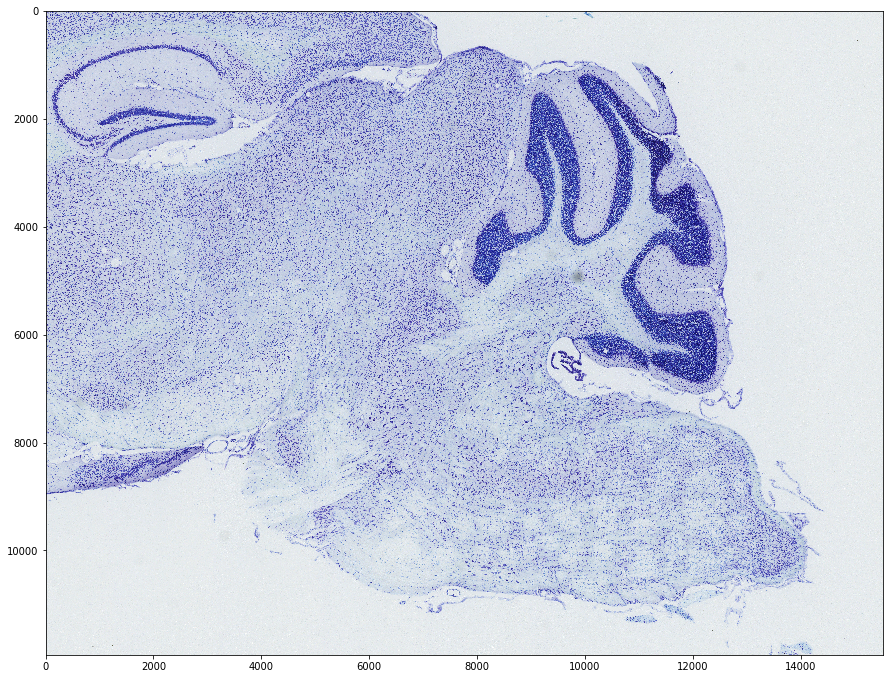

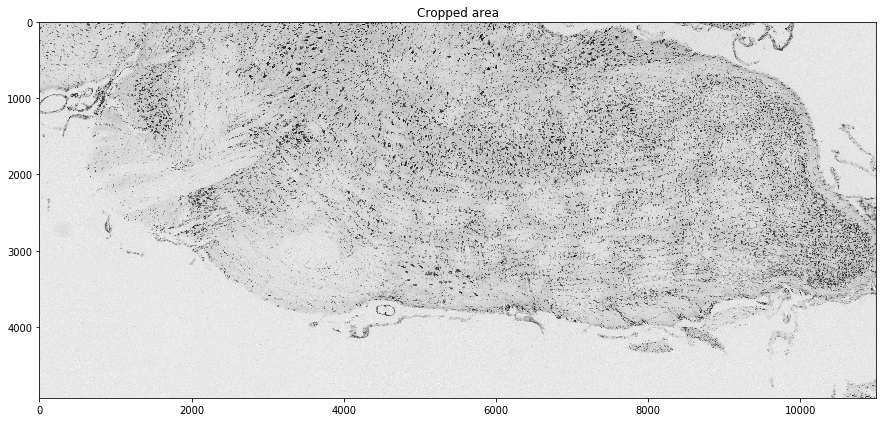

In [7]:
# Show the entire image
plt.figure(figsize=(15,15))
plt.imshow(imread(img_filename[sec]))
# Show the cropped image
plt.figure(figsize=(15,15))
plt.imshow(im_rescale[sec],cmap=plt.cm.gray)
plt.title('Cropped area')
           

### Reconstruct labeled image from detected cell dataset

In [8]:
# Construct BW images
oriImL1,oriImL0 = metadata_cache['image_shape'][stack] # The order is annoying....

In [9]:
option_crop = True
option_clear_border = True
option_relabel = True
im_blob_prop = {}
im_label_ori = {}
im_label = {}
im_BW = {}
crop_range = (crop_0_min,crop_0_max,crop_1_min,crop_1_max)
for tempSec in secList:
    temp_im_label, temp_im_blob_prop, _ = fun_reconstruct_labeled_image(cell_global_coord[tempSec],crop_range= crop_range, 
                                                                    oriImL0=oriImL0,oriImL1=oriImL1)
    im_label[tempSec] = temp_im_label
    im_BW[tempSec] = temp_im_label>0
    im_blob_prop[tempSec]  = np.array(temp_im_blob_prop)

n_blobs = {tempSec: len(im_blob_prop[tempSec]) for tempSec in im_blob_prop.keys()}

### Get indices for blobs in 7N and out of 7N

In [10]:
# Get positive example in 7N
contour, _ = DataManager.load_annotation_v3(stack=stack);
contour = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour,stack=stack)
structure_name = '7N'
vertice_7N_dic = {cnt['section']:cnt['vertices'] for _ , cnt in contour[contour['name'] == structure_name].iterrows()}

'No object named structures in the file'


Annotation has no structures.


In [17]:
temp_BIDInside_7N = {}
temp_BIDOutside_7N = {}
margin = 200
for sec in secList:
    temp_Blob_centroid = [im_blob_prop[sec][tempBID]['centroid'] for tempBID in range(n_blobs[sec])]
    temp_BlobInside_7N =  fun_blobs_in_polygen(temp_Blob_centroid, vertice_7N_dic[sec],crop_min_list=[crop_0_min,crop_1_min])
    temp_BlobOutside_7N = fun_blobs_out_polygen(temp_Blob_centroid, vertice_7N_dic[sec], crop_min_list=[crop_0_min, crop_1_min],margin=margin)
    
    temp_BIDInside_7N[sec] = np.where((temp_BlobInside_7N==True))[0]
    temp_BIDOutside_7N[sec] = np.where((temp_BlobOutside_7N==True))[0]

# Compute similarities between blobs in section with blobs in nearby sections

In [4]:
sec = section_begin + 1
# Parameters
scan_section_range = 1
prop = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter'] # Features for comparison
prop_for_comparison = ['area', 'orientation','moments_hu']
typicalBlobs_dic = {}
matchedBlobs_dic = {}
compare_weight = [1 for i in range(len(prop_for_comparison) + 6)]
compare_weight = np.array(compare_weight)/ float(np.sum(compare_weight))
o_simil_threshold = 0.8
o_scan_size_coeff = 5
o_scan_size = 112
o_fix_scan_size = True
scan_section = range(sec - scan_section_range, sec + scan_section_range + 1)
scan_section.remove(sec)

NameError: name 'section_begin' is not defined

In [ ]:
scan_parameters = {}
scan_parameters['scan_section_range'] = 1
scan_parameters['prop'] = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter']
scan_parameters['prop_for_comparison'] = ['area', 'orientation','moments_hu']
scan_parameters['compare_weight'] = compare_w


In [20]:
typical_blobs = []
matched_paris = []
# for blobID in range(n_blobs[sec]):
for blobID in temp_BIDInside_7N[sec]:
#     if (blobID % 1000) == 0:
#         print('Finished percentage: %f'%(float(blobID)*100 / n_blobs[sec]))
    temp_curr_blob_props = im_blob_prop[sec][blobID]
    tempB1_idx_loc = temp_curr_blob_props['centroid']
    tempB1_orientation = temp_curr_blob_props['orientation']
    tempB1_hu = temp_curr_blob_props['moments_hu']
    tempB1_size = temp_curr_blob_props['area']
    if o_fix_scan_size:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max)
    else:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max)

    #################################
    for tempSec in scan_section:
        if tempSec not in secList:
#             print('Section %d is not in the load image list.'%tempSec);
            continue
        # Find blobs in the scaned section
        temp_im = fun_crop_images(im_label[tempSec],*temp_next_sec_range_1D, margin=0,im0max=im0max, im1max=im1max)
        tempBlobInsideIndex = np.delete(np.unique(temp_im.flatten()),0,axis=0) - 1 # Minus 1 because when reconstructing the labeled image, pixel for blob start at 1
        temp_num_blob = len(tempBlobInsideIndex)
        if temp_num_blob:
            temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
        else:
#             print('No blobs found in this section')
            continue


        # Get blob properties
        temp_next_blob_props = {}
        for tempProp in prop:
            temp_prop_value = []
            for blobIndex in range(temp_num_blob):
                temp_prop_value.append(temp_next_sec_blob_prop[blobIndex][tempProp])
            temp_next_blob_props[tempProp] = temp_prop_value
        temp_next_blob_props['relative_dict'] = []
        for blobIndex in range(temp_num_blob):
            temp_next_blob_props['relative_dict'].append(fun_local_distance(temp_next_sec_blob_prop[blobIndex]['centroid'],local_cloc))

        temp_sim = {}

        for temp_prop in prop_for_comparison:
                temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                         temp_next_blob_props[temp_prop],distance_type=temp_prop))
        temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))

        # Blob comparison


        temp_weighted_sim = np.dot(temp_sim_matrix,compare_weight)
        temp_compare_result = temp_weighted_sim > o_simil_threshold
        if any(temp_compare_result.tolist()):
            typical_blobs.append([sec, blobID, im_blob_prop[sec][blobID]])
            # list of [section, blobID, blob_properties, scan_section, matched_blob_IDs, matched_blobs_properties, match_blob_similarities]
            matched_paris.append([sec,blobID,im_blob_prop[sec][blobID],tempSec, tempBlobInsideIndex[temp_compare_result], im_blob_prop[tempSec][tempBlobInsideIndex[temp_compare_result]],temp_sim_matrix[temp_compare_result,:]])
typicalBlobs_dic[sec] = typical_blobs
matchedBlobs_dic[sec] = matched_paris

In [21]:
matched_paris

[[153,
  12738,
  154,
  array([13696]),
  array([<skimage.measure._regionprops._RegionProperties object at 0x7f972353d810>], dtype=object),
  array([[ 0.05389908,  0.96580087,  0.99103262,  0.98937569,  0.94669811,
           0.97352482,  0.99611113,  0.99110402,  0.72807302]])],
 [153,
  13244,
  154,
  array([14698]),
  array([<skimage.measure._regionprops._RegionProperties object at 0x7f972345d690>], dtype=object),
  array([[ 0.546875  ,  0.98969623,  0.9731521 ,  0.81656413,  0.89653523,
           0.88315986,  0.87384596,  0.80703107,  0.65912917]])],
 [153,
  13732,
  154,
  array([14870]),
  array([<skimage.measure._regionprops._RegionProperties object at 0x7f972347b250>], dtype=object),
  array([[ 0.8       ,  0.91722193,  0.99358416,  0.66910344,  0.97340055,
           0.978111  ,  0.99196242,  0.82996986,  0.94305228]])],
 [153,
  13982,
  152,
  array([16634]),
  array([<skimage.measure._regionprops._RegionProperties object at 0x7f97251f3e90>], dtype=object),
  array([[ 0.

# Negative example

In [22]:
false_typicalBlobs_dic = {}
false_matchedBlobs_dic = {}

In [23]:
# Find compute similarity between blobs in 7N and blobs out of the annotated structure 7N, in the scaned section
false_typical_blobs = []
false_matched_paris = []
# for blobID in range(n_blobs[sec]):
for blobID in temp_BIDInside_7N[sec]:
#     if (blobID % 1000) == 0:
#         print('Finished percentage: %f'%(float(blobID)*100 / n_blobs[sec]))
    temp_curr_blob_props = im_blob_prop[sec][blobID]
    tempB1_idx_loc = temp_curr_blob_props['centroid']
    tempB1_orientation = temp_curr_blob_props['orientation']
    tempB1_hu = temp_curr_blob_props['moments_hu']
    tempB1_size = temp_curr_blob_props['area']
    if o_fix_scan_size:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max)
    else:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max)

    #################################
    for tempSec in scan_section:
        if tempSec not in secList:
#             print('Section %d is not in the load image list.'%tempSec);
            continue
        tempBlobInsideIndex = temp_BIDOutside_7N[sec]
        temp_num_blob = len(tempBlobInsideIndex)
        if temp_num_blob:
            temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
        else:
#             print('No blobs found in this section')
            continue


        # Get blob properties
        temp_next_blob_props = {}
        for tempProp in prop:
            temp_prop_value = []
            for blobIndex in range(temp_num_blob):
                temp_prop_value.append(temp_next_sec_blob_prop[blobIndex][tempProp])
            temp_next_blob_props[tempProp] = temp_prop_value
        temp_next_blob_props['relative_dict'] = []
        for blobIndex in range(temp_num_blob):
            temp_next_blob_props['relative_dict'].append(fun_local_distance(temp_next_sec_blob_prop[blobIndex]['centroid'],local_cloc))

        temp_sim = {}

        for temp_prop in prop_for_comparison:
                temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                         temp_next_blob_props[temp_prop],distance_type=temp_prop))
        temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))

        # Blob comparison


        temp_weighted_sim = np.dot(temp_sim_matrix,compare_weight)
        temp_compare_result = temp_weighted_sim > o_simil_threshold
        if any(temp_compare_result.tolist()):
            false_typical_blobs.append([sec, blobID, im_blob_prop[sec][blobID]])
            # list of [section, blobID, blob_properties, scan_section, matched_blob_IDs, matched_blobs_properties, match_blob_similarities]
            false_matched_paris.append([sec,blobID,im_blob_prop[sec][blobID],tempSec, tempBlobInsideIndex[temp_compare_result], im_blob_prop[tempSec][tempBlobInsideIndex[temp_compare_result]],temp_sim_matrix[temp_compare_result,:]])
false_typicalBlobs_dic[sec] = false_typical_blobs
false_matchedBlobs_dic[sec] = false_matched_paris

### Show 7N in section 153 and 152, with Blob_ID for large blobs

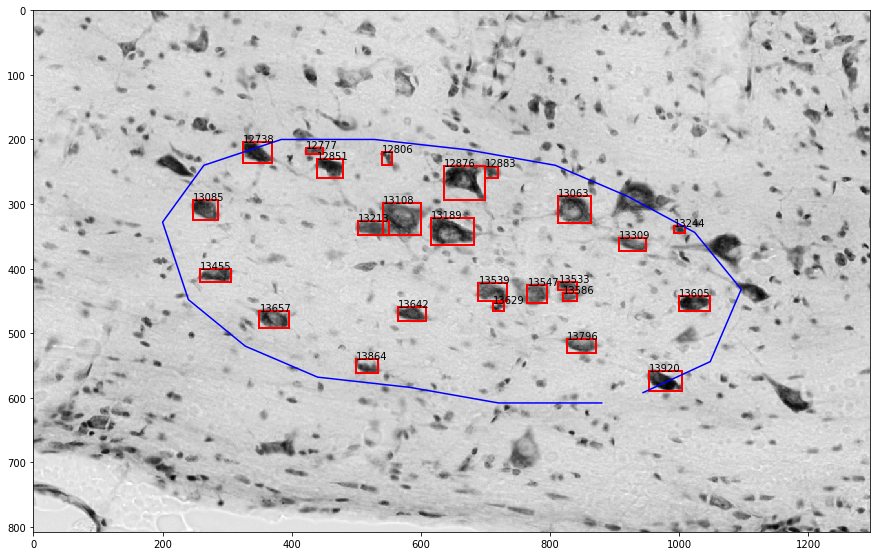

In [24]:
margin = 200
im_1_max,im_0_max = np.max(np.array(vertice_7N_dic[sec],dtype=np.int),axis=0) - np.array([crop_1_min, crop_0_min])
im_1_min,im_0_min = np.min(np.array(vertice_7N_dic[sec],dtype=np.int),axis=0) - np.array([crop_1_min, crop_0_min])

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(fun_crop_images(im_rescale[sec],im_0_min,im_1_min,im_0_max,im_1_max,im0max=im0max,im1max=im1max,margin=margin),cmap=plt.cm.gray)

for prop in im_blob_prop[sec][temp_BIDInside_7N[sec]]:
    if prop['area']>100:
        min0, min1, max0, max1 = prop['bbox'];
        rect = matplotlib.patches.Rectangle((min1-im_1_min + margin,min0-im_0_min + margin),max1-min1, max0-min0, fill=False,edgecolor='red',linewidth=2)
        ax.text(min1-im_1_min + margin, min0-im_0_min + margin, prop['label']-1)
        ax.add_patch(rect)
        
plt.plot(vertice_7N_dic[sec][:,0] - crop_1_min - im_1_min + margin,vertice_7N_dic[sec][:,1]-crop_0_min - im_0_min + margin,'-b')
plt.show()

In [25]:
typical_blob_in_sec153 = [13108, 13189, 12876, 13063]

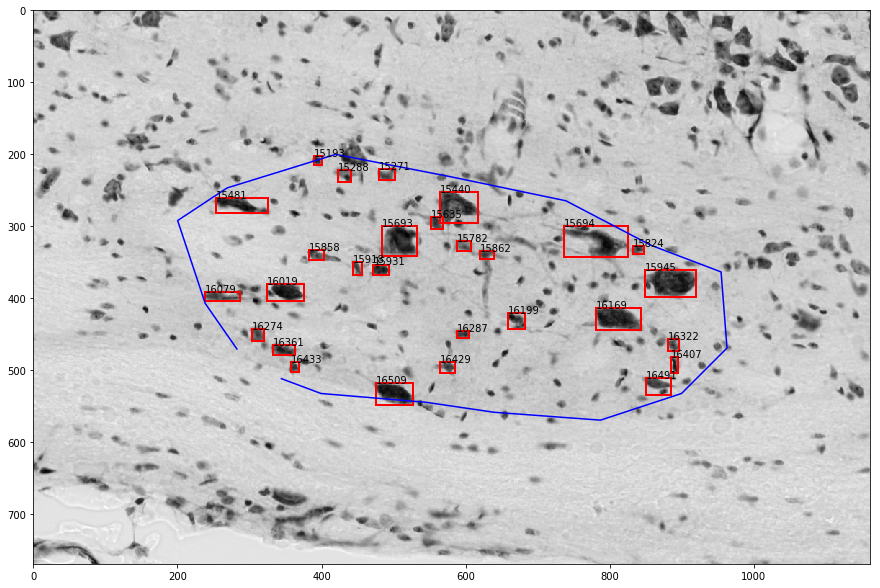

In [190]:
disp_sec = sec - 1
margin = 200
im_1_max,im_0_max = np.max(np.array(vertice_7N_dic[disp_sec],dtype=np.int),axis=0) - np.array([crop_1_min, crop_0_min])
im_1_min,im_0_min = np.min(np.array(vertice_7N_dic[disp_sec],dtype=np.int),axis=0) - np.array([crop_1_min, crop_0_min])

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(fun_crop_images(im_rescale[disp_sec],im_0_min,im_1_min,im_0_max,im_1_max,im0max=im0max,im1max=im1max,margin=margin),cmap=plt.cm.gray)

for prop in im_blob_prop[disp_sec][temp_BIDInside_7N[disp_sec]]:
    if prop['area']>100:
        min0, min1, max0, max1 = prop['bbox'];
        rect = matplotlib.patches.Rectangle((min1-im_1_min + margin,min0-im_0_min + margin),max1-min1, max0-min0, fill=False,edgecolor='red',linewidth=2)
        ax.text(min1-im_1_min + margin, min0-im_0_min + margin, prop['label']-1)
        ax.add_patch(rect)
        
plt.plot(vertice_7N_dic[disp_sec][:,0] - crop_1_min - im_1_min + margin,vertice_7N_dic[disp_sec][:,1]-crop_0_min - im_0_min + margin,'-b')
plt.show()


# Analyzing True-matched blobs
2. why the size histogram of the detected blobs seems so smooth? If there are different kind of cells in the brain, why we cannot see several peaks in the histogram?
3. What are the similarity between blobs that we think are 'typical'?

### Cannot find much matched cells. Only 4 bolbs are classified as 'typical', and three of them are small cells size = 128, 16, 25. To get more blobs that we think are 'typical' classifised as typical, we can a) lower the threnshold or b) emphasizing more on the size of the blob

In [27]:
# index of the typical blobs and their sizes
[[matchedBlobs_dic[sec][tempIdx][2]['label']-1,matchedBlobs_dic[sec][tempIdx][2]['area']] for tempIdx in range(len(matchedBlobs_dic[sec]))]

[[12738, 872], [13244, 128], [13732, 16], [13982, 25]]

### The cell-detection software detects much more blobs in section 152 and 154 than section 153. Looking from the image by naked eyes, it seems that the software neglected a lot of small blobs for unknown reasons. So the number of detected small blobs might be severely underestimated.

In [28]:
# Number of detected blobs
map(len,temp_BIDInside_7N.values())

[112, 57, 229]

## Compute similarities between blobs in labeled region in different sections

In [30]:
test_typicalBlobs_dic = {}
test_matchedBlobs_dic = {}
test_infoRecord_dic = {}

In [31]:
# Find compute similarity between blobs in 7N and blobs out of the annotated structure 7N, in the scaned section
test_typical_blobs = []
test_matched_paris = []
test_infoRecord = []
# for blobID in range(n_blobs[sec]):
for blobID in temp_BIDInside_7N[sec]:
#     if (blobID % 1000) == 0:
#         print('Finished percentage: %f'%(float(blobID)*100 / n_blobs[sec]))
    temp_curr_blob_props = im_blob_prop[sec][blobID]
    tempB1_idx_loc = temp_curr_blob_props['centroid']
    tempB1_orientation = temp_curr_blob_props['orientation']
    tempB1_hu = temp_curr_blob_props['moments_hu']
    tempB1_size = temp_curr_blob_props['area']
    if o_fix_scan_size:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max)
    else:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max)

    #################################
    for tempSec in scan_section:
        if tempSec not in secList:
#             print('Section %d is not in the load image list.'%tempSec);
            continue
        tempBlobInsideIndex = temp_BIDInside_7N[tempSec]
        temp_num_blob = len(tempBlobInsideIndex)
        if temp_num_blob:
            temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
        else:
#             print('No blobs found in this section')
            continue


        # Get blob properties
        temp_next_blob_props = {}
        for tempProp in prop:
            temp_prop_value = []
            for blobIndex in range(temp_num_blob):
                temp_prop_value.append(temp_next_sec_blob_prop[blobIndex][tempProp])
            temp_next_blob_props[tempProp] = temp_prop_value
        temp_next_blob_props['relative_dict'] = []
        for blobIndex in range(temp_num_blob):
            temp_next_blob_props['relative_dict'].append(fun_local_distance(temp_next_sec_blob_prop[blobIndex]['centroid'],local_cloc))

        temp_sim = {}

        for temp_prop in prop_for_comparison:
                temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                         temp_next_blob_props[temp_prop],distance_type=temp_prop))
        temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))

        # Blob comparison


        temp_weighted_sim = np.dot(temp_sim_matrix,compare_weight)
        temp_compare_result = temp_weighted_sim > o_simil_threshold
        test_infoRecord.append([sec, blobID, tempBlobInsideIndex, temp_weighted_sim, temp_sim_matrix])
        if any(temp_compare_result.tolist()):
            test_typical_blobs.append([sec, blobID, im_blob_prop[sec][blobID]])
            # list of [section, blobID, blob_properties, scan_section, matched_blob_IDs, matched_blobs_properties, match_blob_similarities]
            test_matched_paris.append([sec,blobID,im_blob_prop[sec][blobID],tempSec, tempBlobInsideIndex[temp_compare_result], im_blob_prop[tempSec][tempBlobInsideIndex[temp_compare_result]],temp_sim_matrix[temp_compare_result,:]])
test_typicalBlobs_dic[sec] = test_typical_blobs
test_matchedBlobs_dic[sec] = test_matched_paris
test_infoRecord_dic[sec] = test_infoRecord

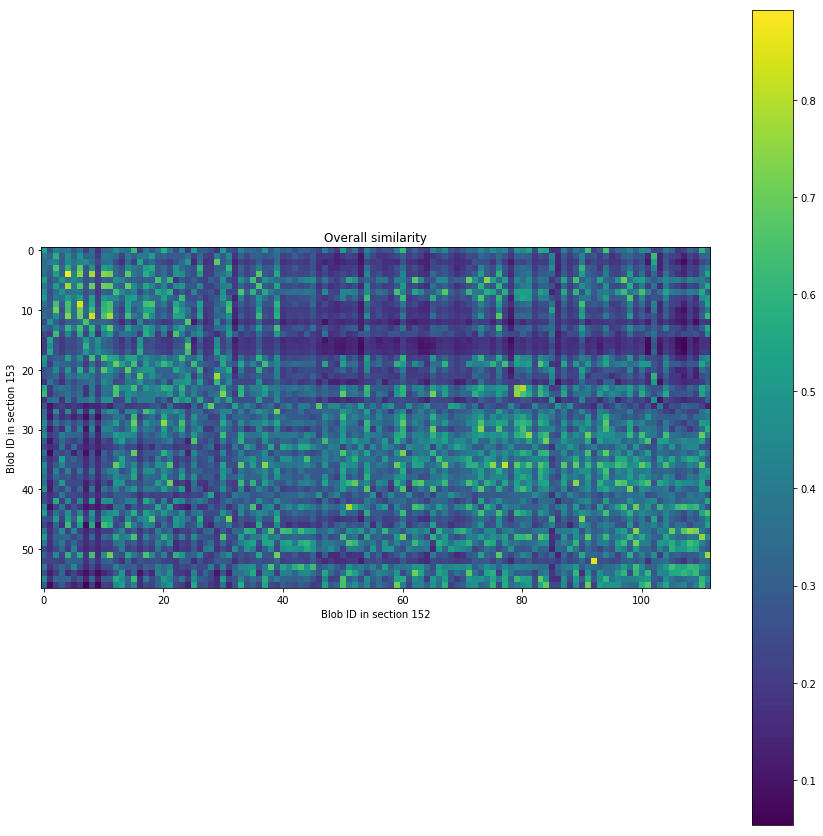

In [186]:
temp_sec_idx_order_by_area = np.array([temp['area'] for temp in im_blob_prop[sec][temp_BIDInside_7N[sec]]]).argsort()[::-1]
temp_disp_sec_idx_order_by_area = np.array([temp['area'] for temp in im_blob_prop[disp_sec][temp_BIDInside_7N[disp_sec]]]).argsort()[::-1]
temp_test_sim_wrt_prv_sec = np.row_stack((test_infoRecord_dic[sec][tempBID][3][temp_disp_sec_idx_order_by_area] for tempBID in range(len(test_infoRecord_dic[sec])) if tempBID%2==0))
plt.figure(figsize=(15,15))
plt.imshow(temp_test_sim_wrt_prv_sec[temp_sec_idx_order_by_area,:])
plt.colorbar()
plt.xlabel('Blob ID in section %d'%(sec-1))
plt.ylabel('Blob ID in section %d'%sec)
plt.title('Overall similarity')

### This figure shows the overall similarity between blobs in 7N of section 153 and blobs in 7N of section 152. The indices of blobs in both sections are sorted according to the size of blobs and therefore pixel (0,0) represents the overall similarity between the largest blob in (7N, section 153) and the largest blob in (7N, section 152). 

### With uniformly-distributed weights, the overall similarity works OK: many of the highly similar pairs located on the diagonal block of the matrix (upper left and lower right), but here are some "good match" between large blobs with small blobs (upper right and lower left block of the matrix). The dark straight stripe indicates blobs that cannot find similar blobs in the other section, while the bright straight stripes show blob that can find many similar blobs in the other section. 



In [73]:
temp_test_sim_wrt_prv_sec[temp_test_sim_wrt_prv_sec>0.8]

array([ 0.85370829,  0.85457402,  0.81750584,  0.83495324,  0.89264382])

## Some blobs are indeed matched for multiple times. 

In [189]:
np.row_stack(np.where(temp_test_sim_wrt_prv_sec>0.7)).T

array([[  0,   4],
       [  0,   8],
       [  0,  10],
       [  3,  99],
       [  3, 108],
       [  3, 109],
       [  5,  39],
       [  7,   6],
       [  9,  92],
       [ 10,  12],
       [ 11,  81],
       [ 11,  91],
       [ 19,  37],
       [ 19,  67],
       [ 19,  75],
       [ 19,  77],
       [ 21,  15],
       [ 21,  20],
       [ 23,  60],
       [ 25,   4],
       [ 25,   6],
       [ 25,   8],
       [ 25,  11],
       [ 27,  79],
       [ 27,  80],
       [ 29,  73],
       [ 34,   2],
       [ 34,   6],
       [ 36,  29],
       [ 38,  62],
       [ 39,  30],
       [ 39,  65],
       [ 39,  79],
       [ 41,  74],
       [ 42,  31],
       [ 42,  90],
       [ 43, 110],
       [ 45,  91],
       [ 49,  51],
       [ 49,  99],
       [ 50,   4],
       [ 50,   6],
       [ 50,   8],
       [ 50,  10],
       [ 50,  11],
       [ 51,  99],
       [ 52,  84],
       [ 53,  21],
       [ 53,  89],
       [ 55,  11],
       [ 55,  39],
       [ 55, 111],
       [ 56,

### This list shows the pairs of blob indices in two sections that are matched with overall similarity larger than 0.7. Some blobs are indeed matched for multiple times, for example, blob 0 in section 153 matches with blob 4, 8, 10 in section 152. We show the image of each pair of blobs in the following. The overall similarity and the similarity vectors are printed before the image. The similarity vecotr are organized in the order of [area, orientation, 7*hu_moments]

Overall Similarity:0.777022
Similarity vector:
[ 0.63696129  0.94287453  0.92364206  0.71369181  0.86159187  0.84295958
  0.80935539  0.97701404  0.2851073 ]


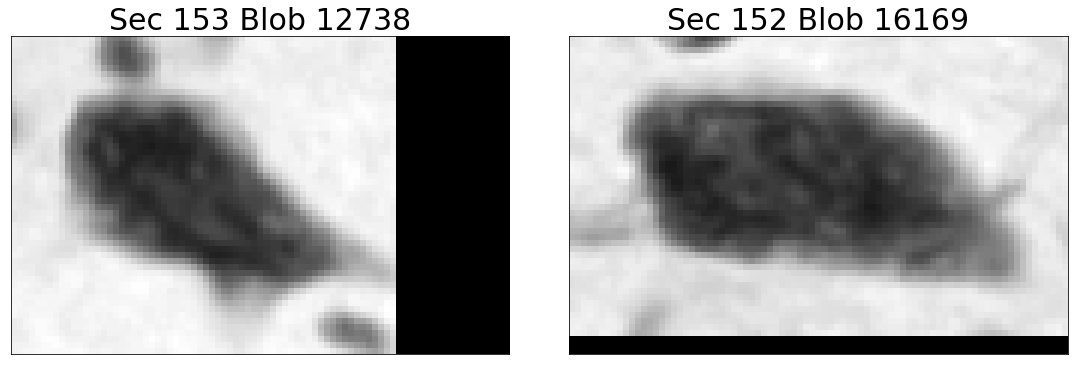

Overall Similarity:0.701553
Similarity vector:
[ 0.34059633  0.94420993  0.84428672  0.48687911  0.92723084  0.76568096
  0.69353374  0.55044908  0.7611092 ]


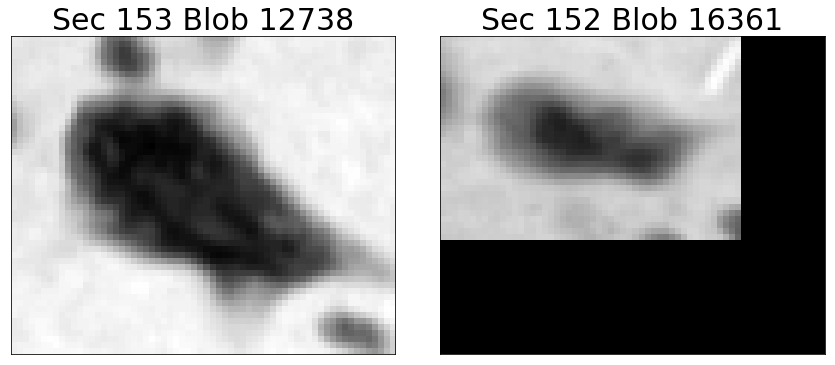

Overall Similarity:0.702234
Similarity vector:
[ 0.4587156   0.99463415  0.80394035  0.54662245  0.90810089  0.91195147
  0.92040202  0.42857653  0.34715845]


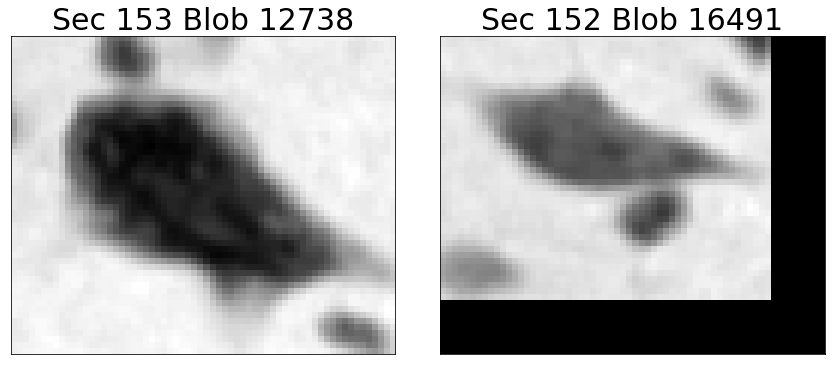

Overall Similarity:0.749313
Similarity vector:
[ 1.          0.96638116  0.95121951  0.58215115  0.41181862  0.92534702
  0.25144551  0.81424824  0.84120352]


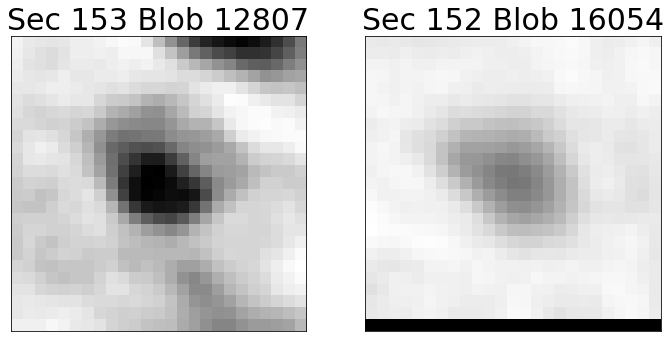

Overall Similarity:0.736155
Similarity vector:
[ 0.73913043  0.99840638  0.98866727  0.60805456  0.81681022  0.78602817
  0.27296896  0.46589849  0.94942753]


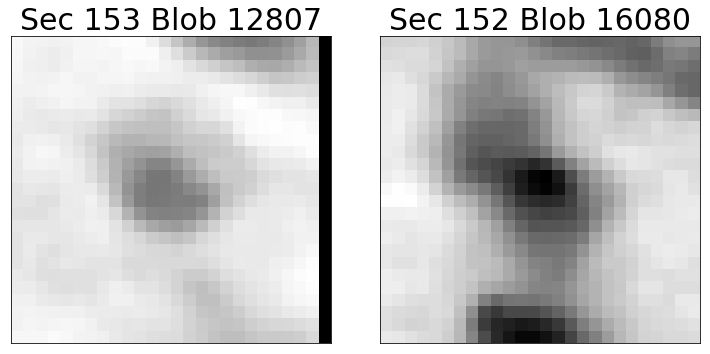

Overall Similarity:0.720836
Similarity vector:
[ 1.          0.7100885   0.95121951  0.58215115  0.41181862  0.92534702
  0.25144551  0.81424824  0.84120352]


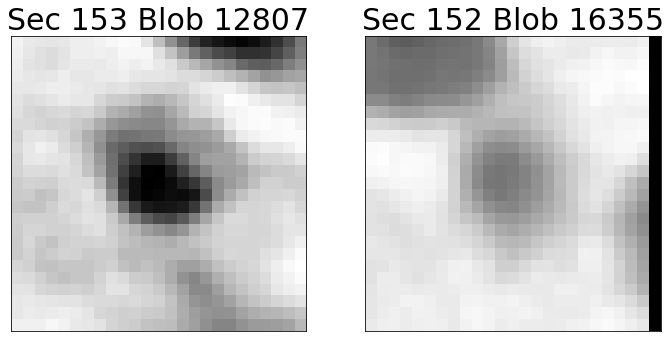

Overall Similarity:0.716201
Similarity vector:
[ 0.90410959  0.40248707  0.88876924  0.29680527  0.72097171  0.76100132
  0.88384331  0.84613744  0.74168179]


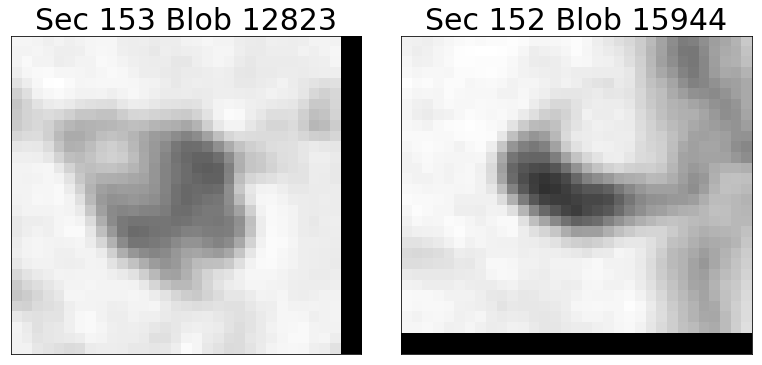

Overall Similarity:0.853708
Similarity vector:
[ 0.90955414  0.95594712  0.93344371  0.67697067  0.60602822  0.91360344
  0.91128044  0.97962326  0.79692357]


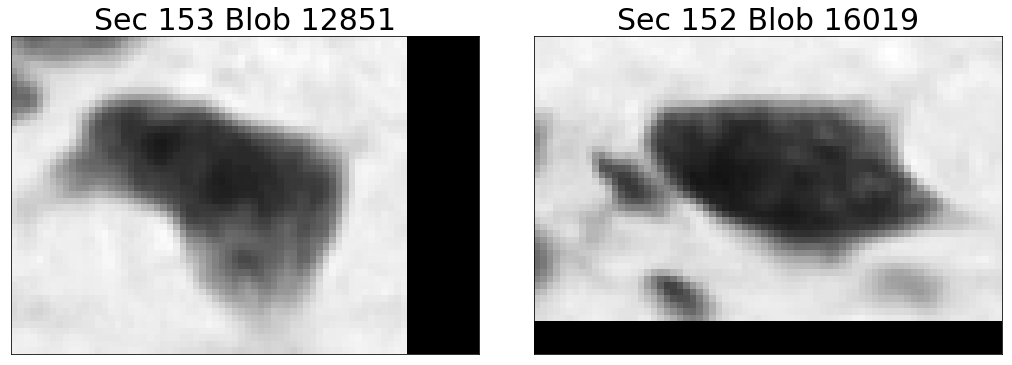

Overall Similarity:0.854574
Similarity vector:
[ 0.46666667  0.91441515  0.85859515  0.45148923  1.          1.          1.
  1.          1.        ]


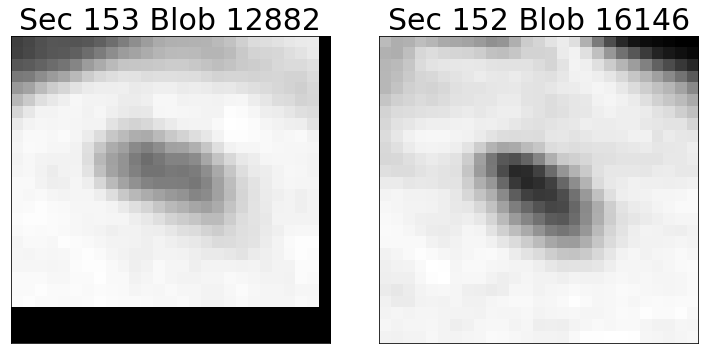

Overall Similarity:0.704910
Similarity vector:
[ 0.92083333  0.85965895  0.98074565  0.59798949  0.16859265  0.66682763
  0.73792174  0.51966442  0.8919572 ]


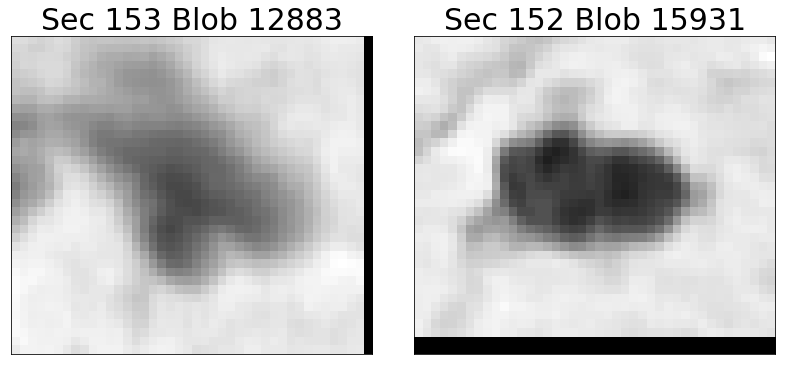

Overall Similarity:0.752180
Similarity vector:
[ 0.84444444  0.88475398  0.98867634  0.99136085  0.92404225  0.80017826
  0.55242114  0.02144454  0.76229876]


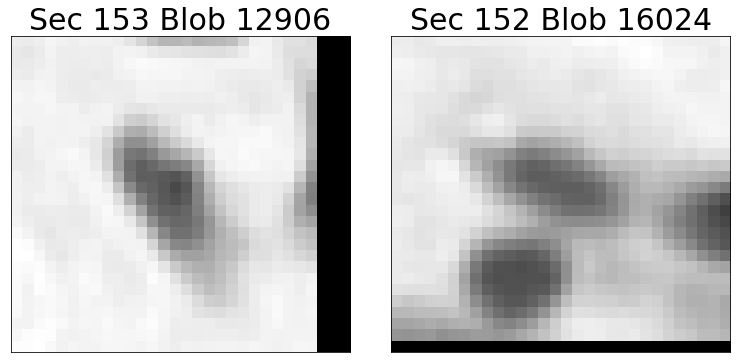

Overall Similarity:0.701845
Similarity vector:
[ 0.81578947  0.99963732  0.86683604  0.18025648  0.73221812  0.88567799
  0.79613957  0.0488458   0.99120644]


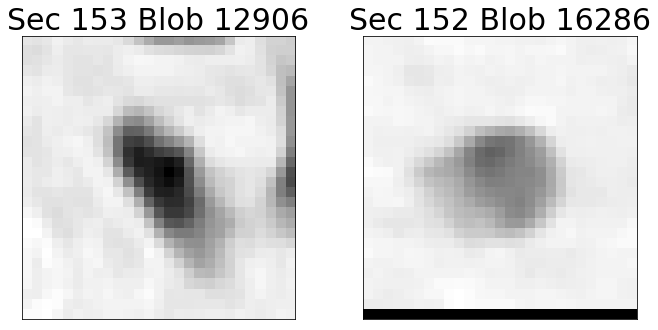

Overall Similarity:0.742644
Similarity vector:
[ 0.3943662   0.99972982  0.97009285  0.62913023  0.99910893  0.85808559
  0.68172002  0.88605897  0.26550002]


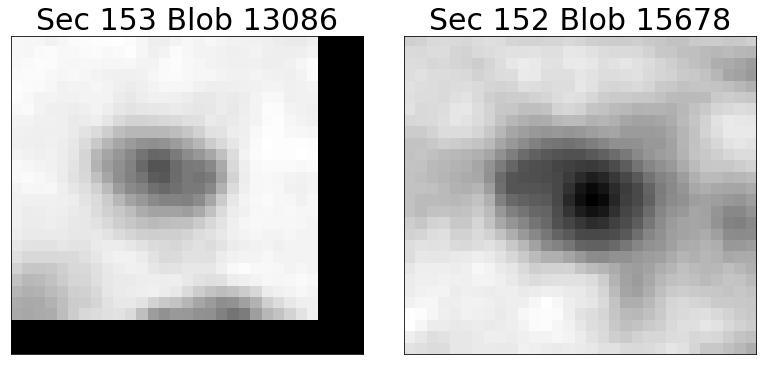

Overall Similarity:0.705310
Similarity vector:
[ 0.56        0.99566405  0.96895474  0.63035893  0.78950581  0.92319229
  0.66437271  0.35573351  0.46000956]


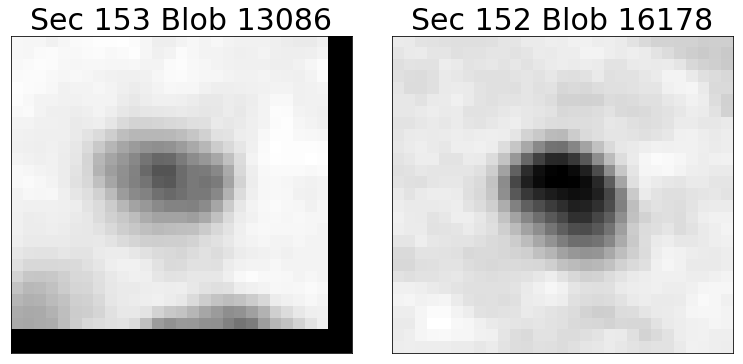

Overall Similarity:0.817506
Similarity vector:
[ 0.60869565  0.79951617  0.98881374  0.81699451  0.78159626  0.98237649
  0.97265265  0.96628769  0.44061943]


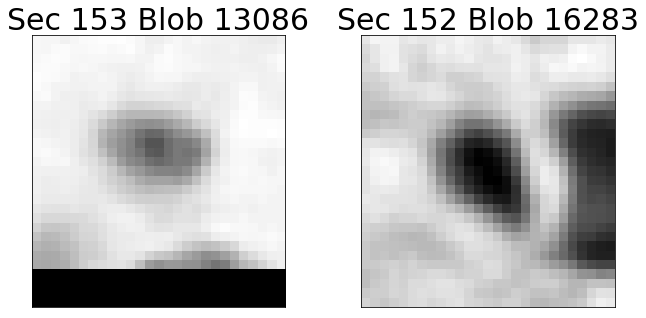

Overall Similarity:0.750120
Similarity vector:
[ 0.59574468  0.82379453  0.95727537  0.53240215  0.62622182  0.99226484
  0.90409573  0.90632401  0.41295436]


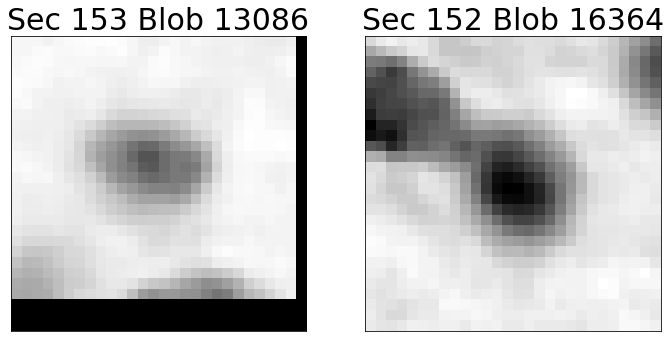

Overall Similarity:0.703337
Similarity vector:
[ 0.26589595  0.81643991  0.96270306  0.92776497  0.50470602  0.87552442
  0.59276729  0.69455828  0.68967731]


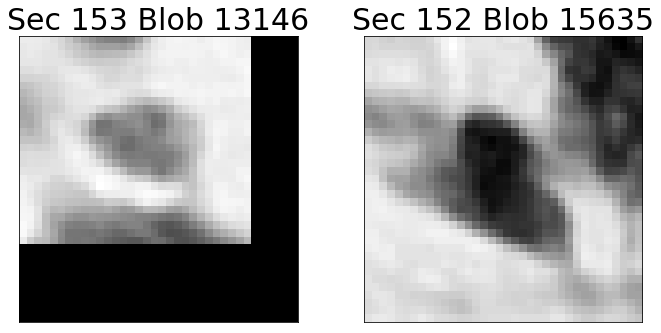

Overall Similarity:0.752131
Similarity vector:
[ 0.32167832  0.8095906   0.97193122  0.92723414  0.81100674  0.99512472
  0.798182    0.27234659  0.86208133]


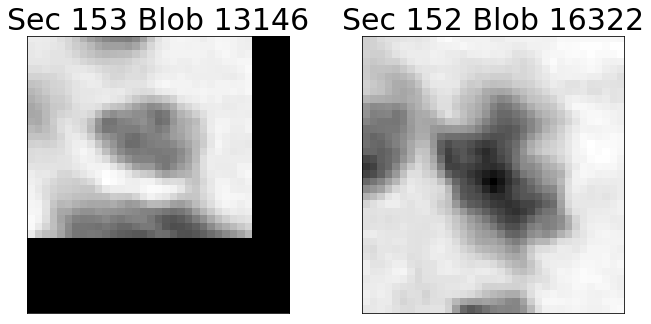

Overall Similarity:0.721790
Similarity vector:
[ 0.63461538  0.44337812  0.88284136  0.21563048  0.97180839  0.99691422
  0.6198907   0.94960975  0.78142575]


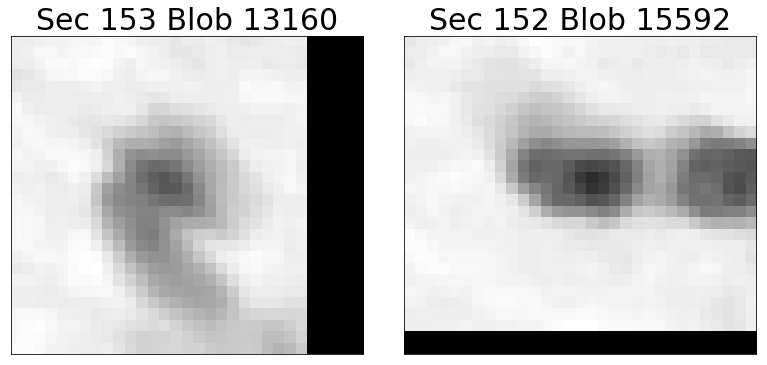

Overall Similarity:0.700371
Similarity vector:
[ 0.82675159  0.99998223  0.91806381  0.69007328  0.95946677  0.54630583
  0.31250029  0.28044022  0.76975939]


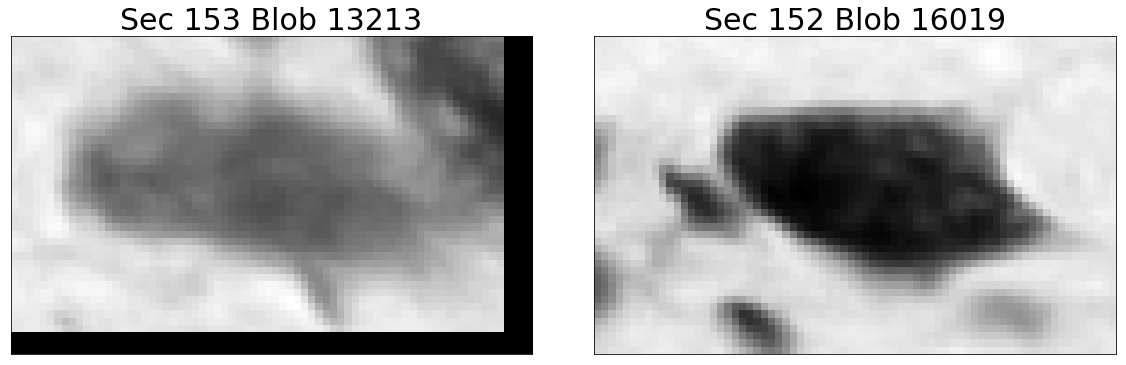

Overall Similarity:0.737701
Similarity vector:
[ 0.47406866  0.99644417  0.9252789   0.74316843  0.77199217  0.83619164
  0.70033263  0.39938377  0.79245045]


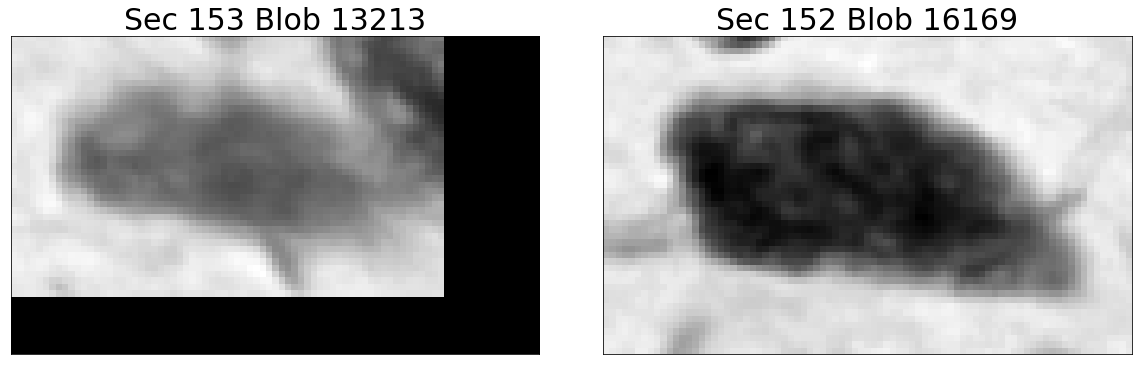

Overall Similarity:0.783049
Similarity vector:
[ 0.40832049  0.85789313  0.9949331   0.81946207  0.72337052  0.98481933
  0.82328605  0.51128474  0.92406949]


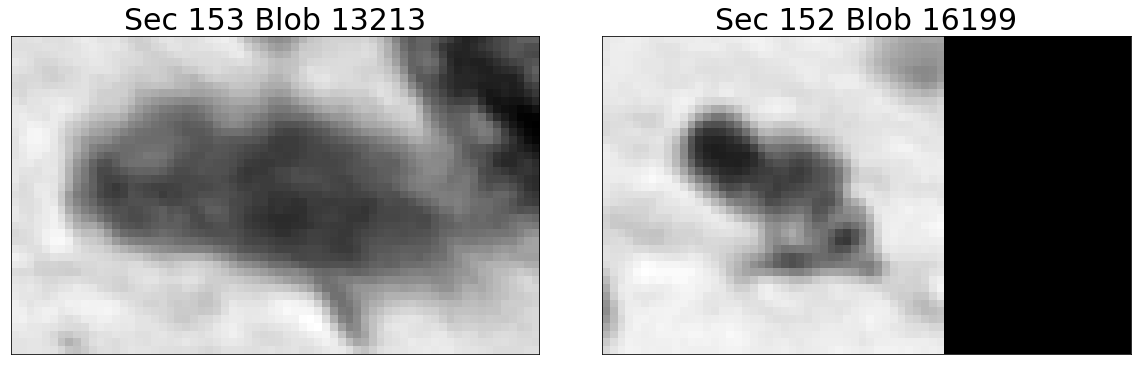

Overall Similarity:0.834953
Similarity vector:
[ 0.61633282  0.94912344  0.94069204  0.97030999  0.73245405  0.90462961
  0.79642092  0.95380858  0.65080773]


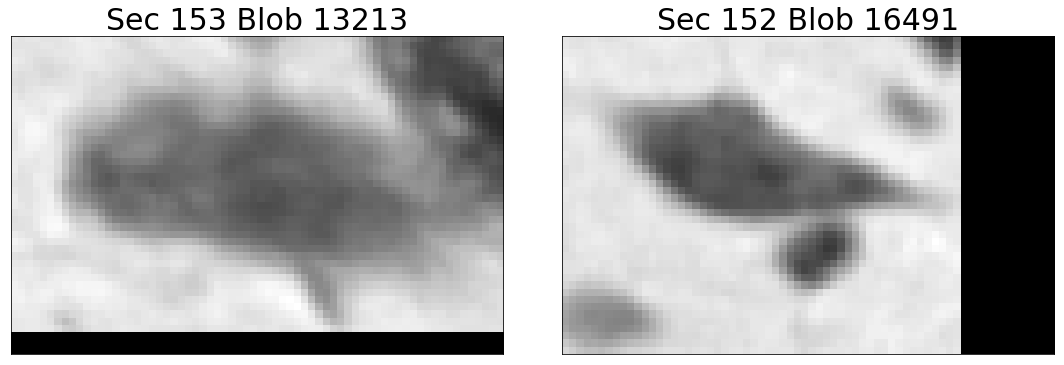

Overall Similarity:0.736372
Similarity vector:
[ 0.3515625   0.93460691  0.99557336  0.88701137  0.71852001  0.67937496
  0.47106929  0.72153992  0.86809073]


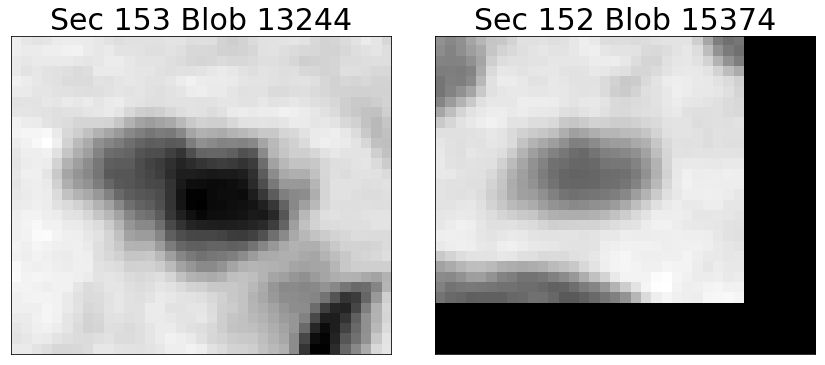

Overall Similarity:0.791911
Similarity vector:
[ 0.3515625   0.80061548  0.98892999  0.81072389  0.98742969  0.98219293
  0.99132651  0.88109545  0.33332009]


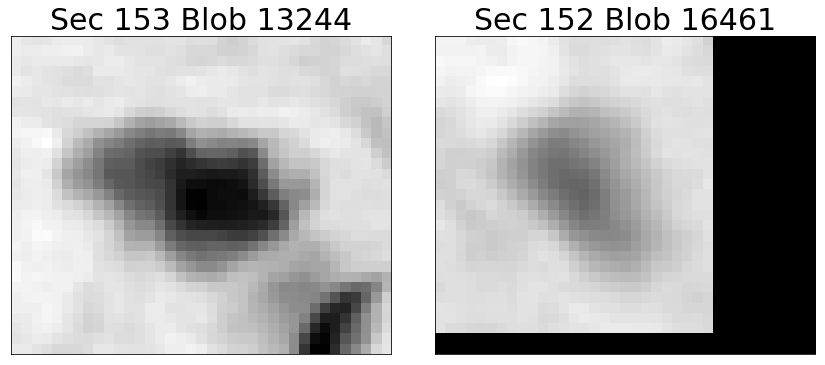

Overall Similarity:0.739258
Similarity vector:
[ 0.85106383  0.27017102  0.90224477  0.55513052  0.84988312  0.78872875
  0.47418261  0.99155742  0.97035763]


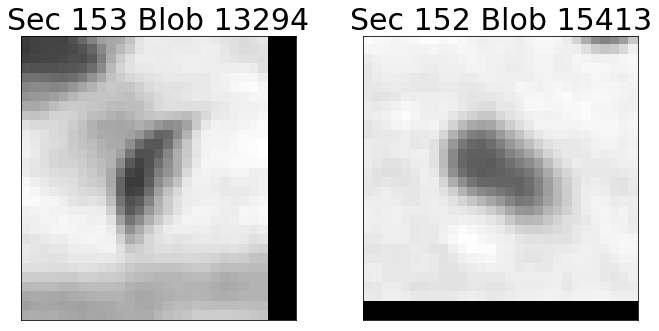

Overall Similarity:0.715490
Similarity vector:
[ 0.49492017  0.99886487  0.75009261  0.13322042  0.62530134  0.92422623
  0.71694905  0.85509121  0.94074045]


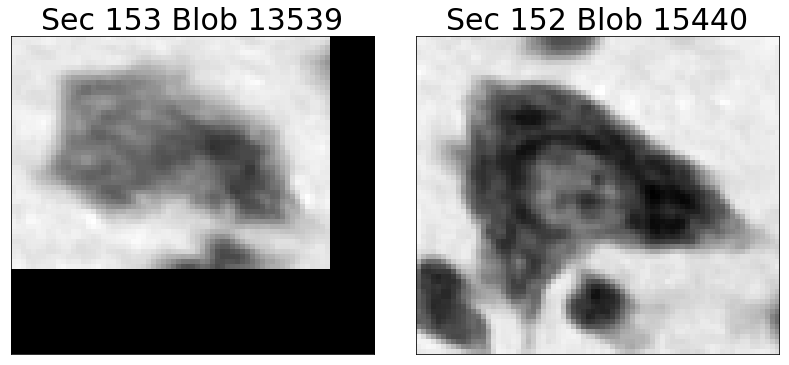

Overall Similarity:0.708406
Similarity vector:
[ 0.86878981  0.99696605  0.86317858  0.70477228  0.38775866  0.97830276
  0.72415295  0.60009369  0.25163518]


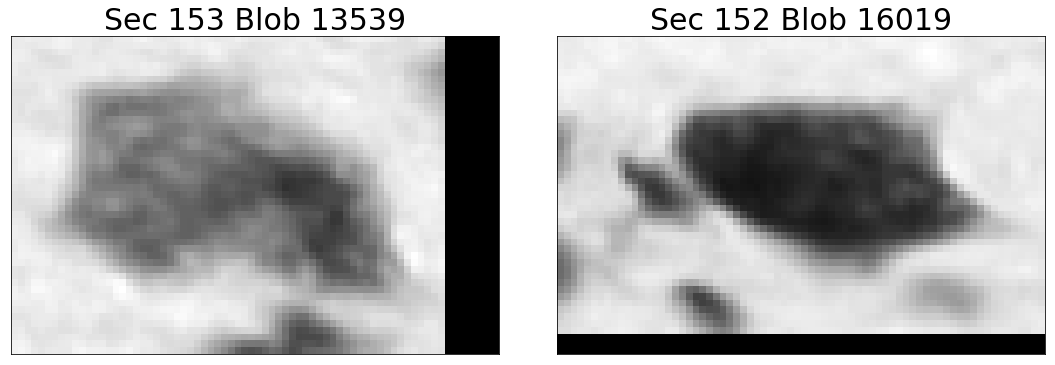

Overall Similarity:0.772030
Similarity vector:
[ 0.61146497  0.94369263  0.87802985  0.83926887  0.57737205  0.76840039
  0.99052497  0.9905441   0.34896805]


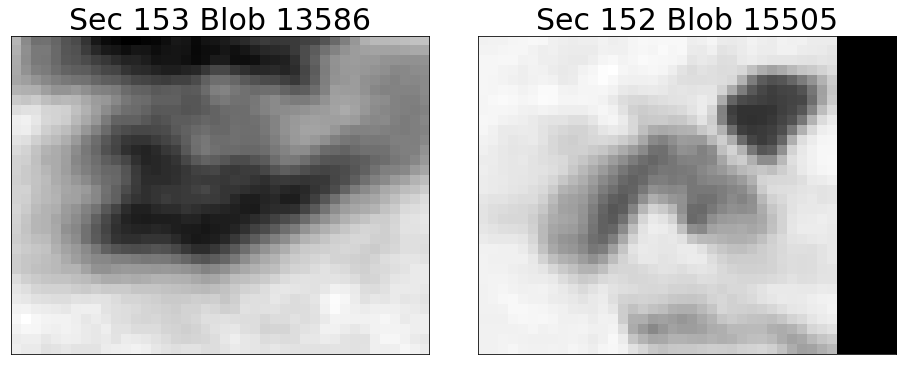

Overall Similarity:0.705920
Similarity vector:
[ 0.25490196  0.96320568  0.95405802  0.45069703  0.56098695  0.90447533
  0.40077707  0.91467947  0.94950189]


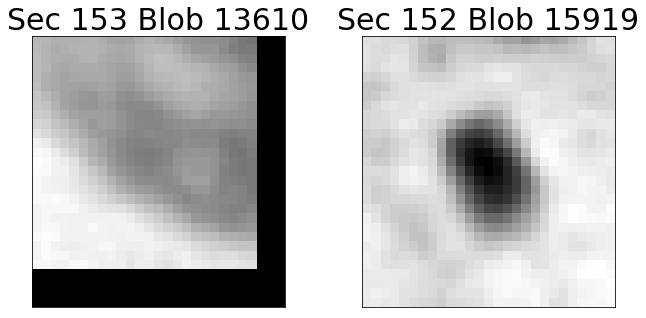

Overall Similarity:0.752926
Similarity vector:
[ 0.40909091  0.93244982  0.87894032  0.56596981  0.88688739  0.99172348
  0.97118701  0.74328022  0.39680911]


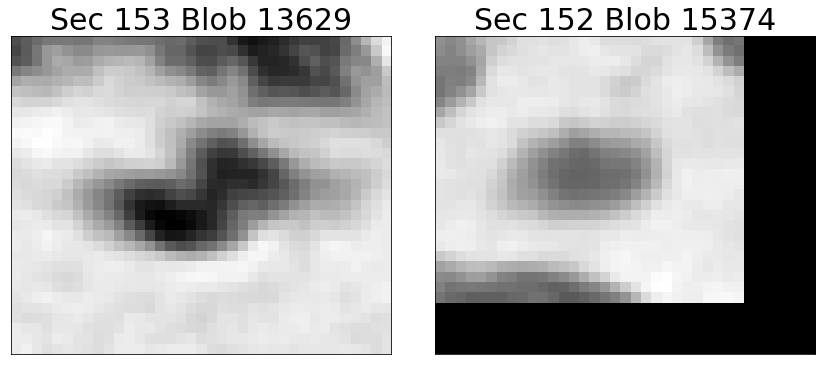

Overall Similarity:0.734771
Similarity vector:
[ 0.87272727  0.77943035  0.9554845   0.91303235  0.67635876  0.90019974
  0.67123334  0.40771859  0.43675773]


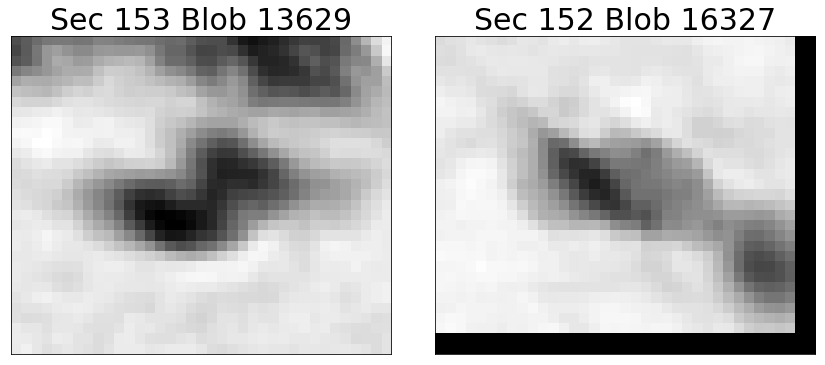

Overall Similarity:0.717693
Similarity vector:
[ 0.45454545  0.7036909   0.96836168  0.72898234  0.57777004  0.93752935
  0.74934238  0.89146036  0.44755168]


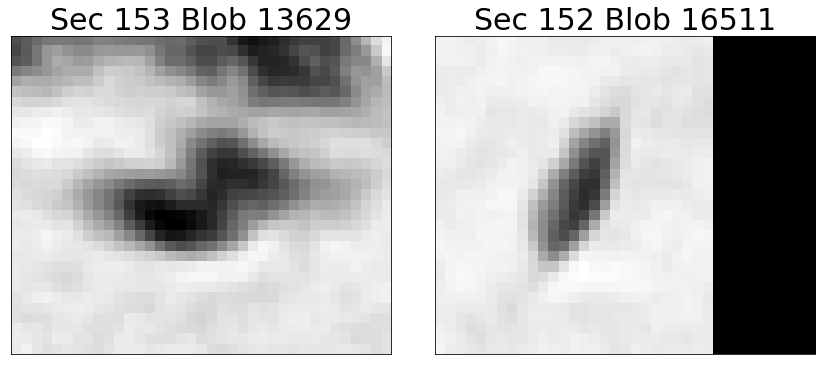

Overall Similarity:0.742105
Similarity vector:
[ 0.05322763  0.97874885  0.96899489  0.83215836  0.88939719  0.96340314
  0.61871179  0.74437695  0.62992439]


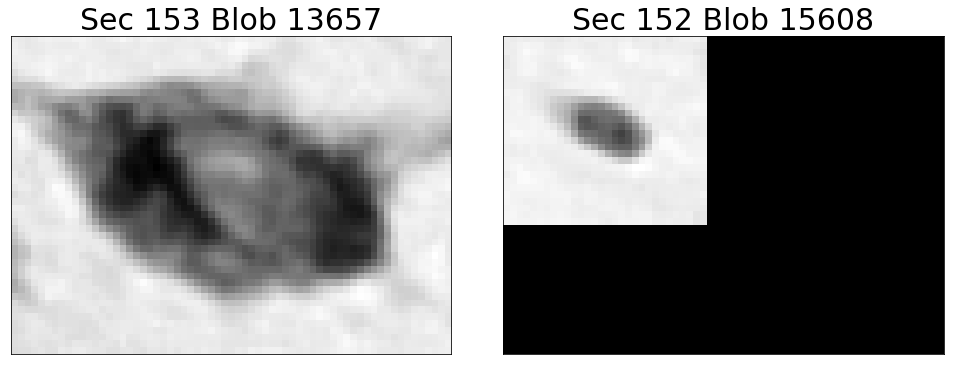

Overall Similarity:0.732085
Similarity vector:
[ 0.5625      0.9133181   0.95900126  0.87618802  0.54788707  0.98214804
  0.75846424  0.63448084  0.35477997]


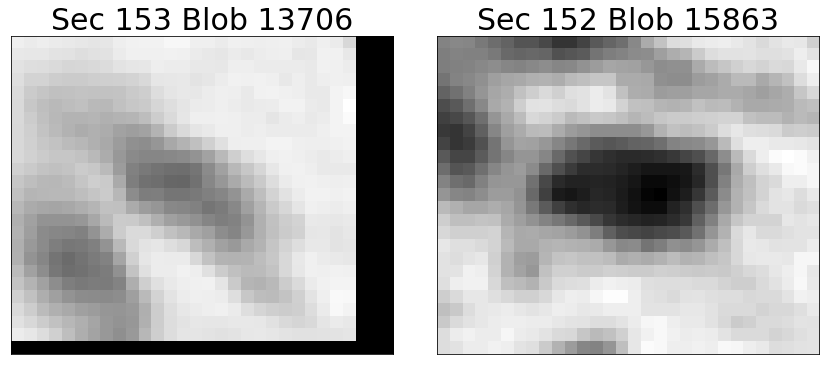

Overall Similarity:0.725036
Similarity vector:
[ 0.2195122   0.95516577  0.77062762  0.52202309  0.74379993  0.98512953
  0.78700694  0.68230388  0.85975663]


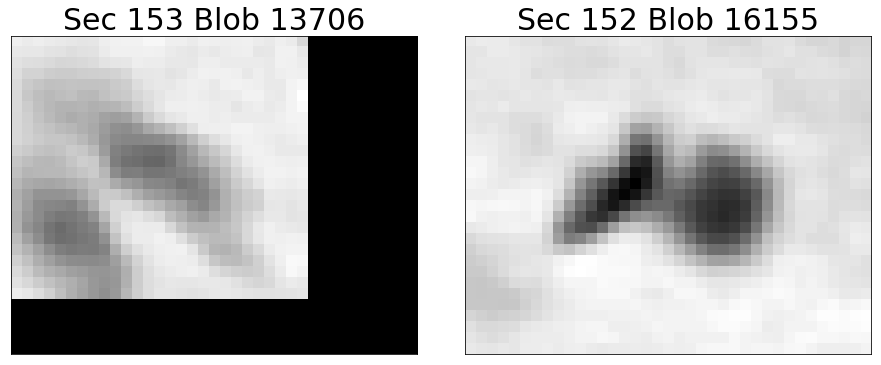

Overall Similarity:0.750456
Similarity vector:
[ 0.875       0.90778311  0.97656653  0.76275749  0.79370968  0.76233891
  0.27380782  0.55706399  0.84507301]


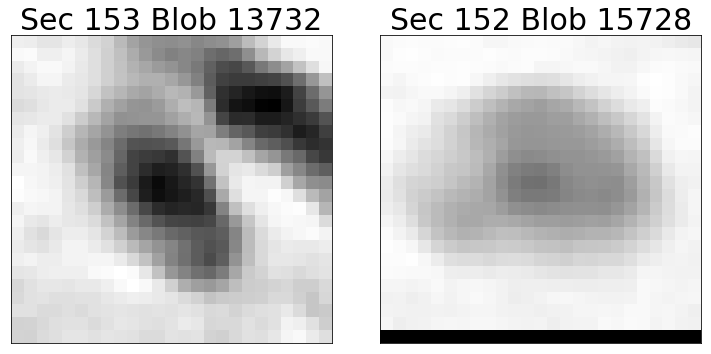

Overall Similarity:0.701106
Similarity vector:
[ 0.35483871  0.59711451  0.9432528   0.83733915  0.99876954  0.57442905
  0.93098525  0.72205891  0.35116184]


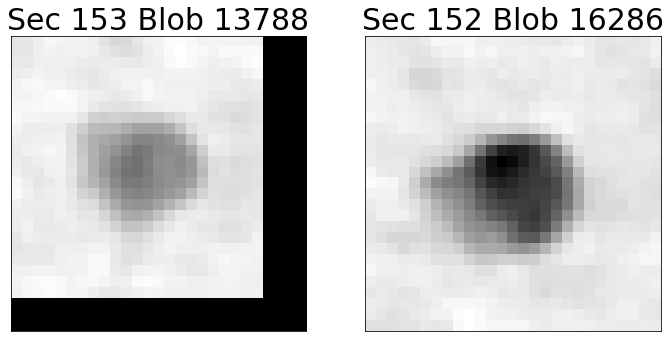

Overall Similarity:0.700898
Similarity vector:
[ 0.91304348  0.06361919  0.95680352  0.65640806  0.90832449  0.71750375
  0.55696819  0.91518194  0.62022633]


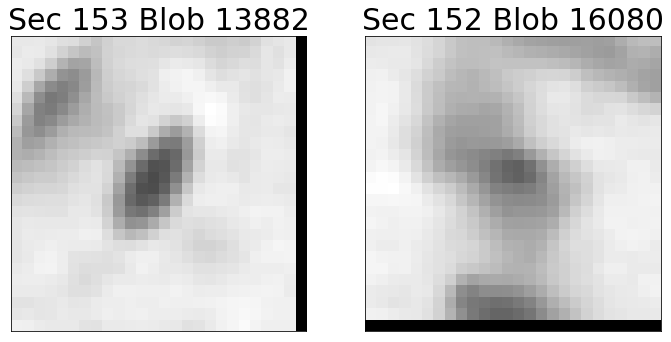

Overall Similarity:0.771956
Similarity vector:
[ 0.36206897  0.97589209  0.99757931  0.87718639  0.90568928  0.97817944
  0.52121771  0.67323205  0.65655788]


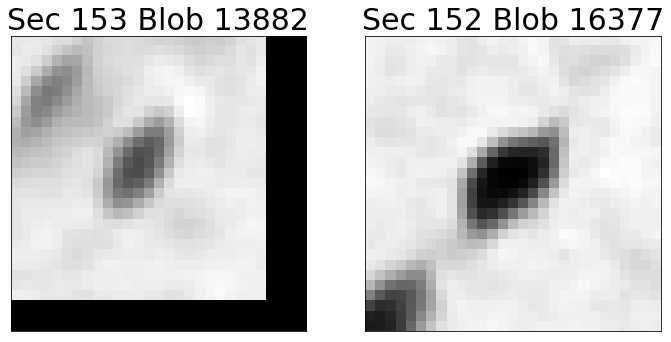

Overall Similarity:0.741918
Similarity vector:
[ 0.85048754  0.96514426  0.99355081  0.96046455  0.74082109  0.62734916
  0.43681289  0.73282217  0.36980614]


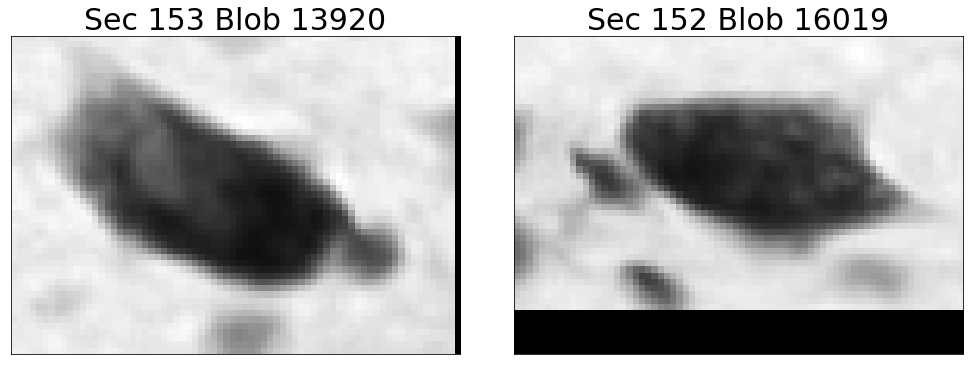

Overall Similarity:0.892644
Similarity vector:
[ 0.67421476  0.98267615  0.98580335  0.96677768  0.92072595  0.96023893
  0.97892491  0.95818924  0.60624337]


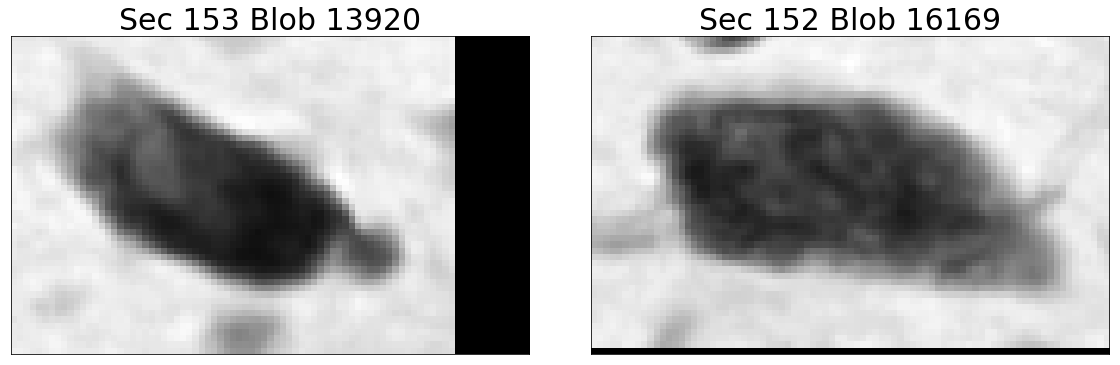

Overall Similarity:0.718735
Similarity vector:
[ 0.28710726  0.96406989  0.9075213   0.87676865  0.51416686  0.85759666
  0.86896888  0.74847772  0.44393946]


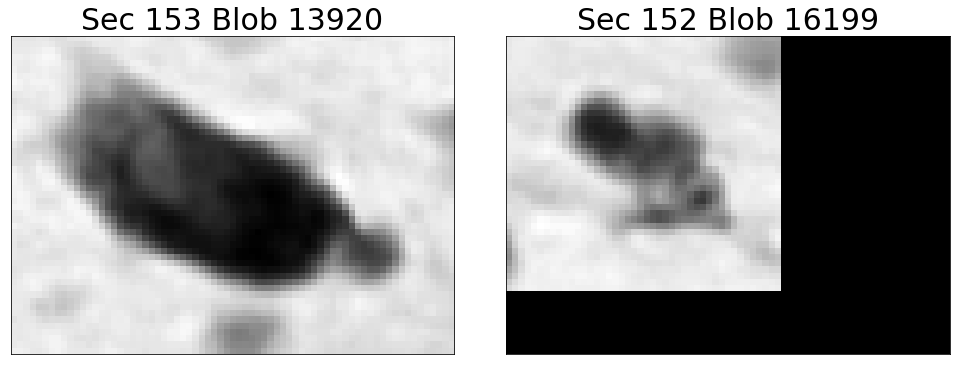

Overall Similarity:0.738937
Similarity vector:
[ 0.32177681  0.98341532  0.90110738  0.65953379  0.86767899  0.87220868
  0.83883725  0.58798338  0.61789454]


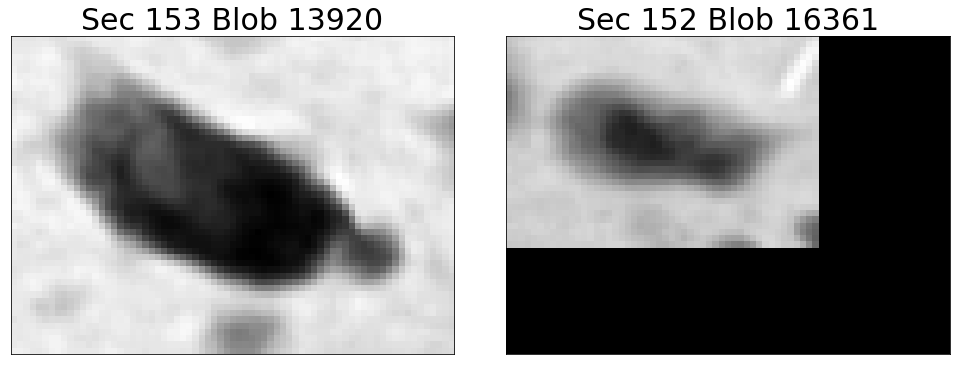

Overall Similarity:0.777932
Similarity vector:
[ 0.43336945  0.9987706   0.85804569  0.74046301  0.97042704  0.96262185
  0.89828122  0.40121806  0.73818704]


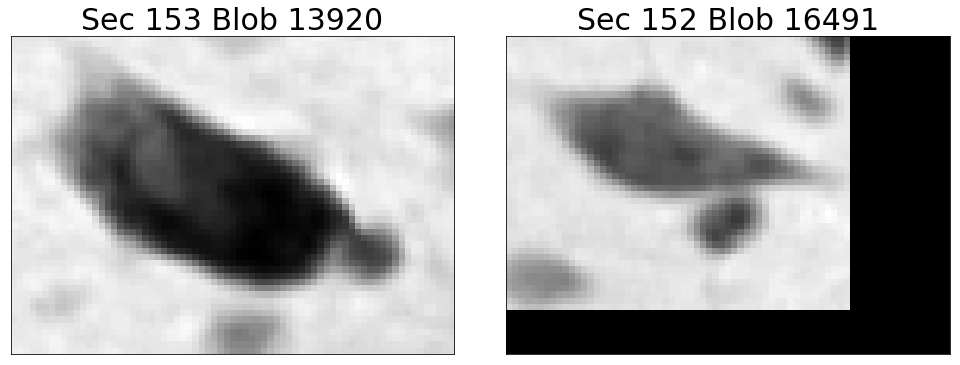

Overall Similarity:0.714746
Similarity vector:
[ 0.69565217  0.9665077   0.98051178  0.74602962  0.83613497  0.71100279
  0.25317918  0.89947826  0.34421465]


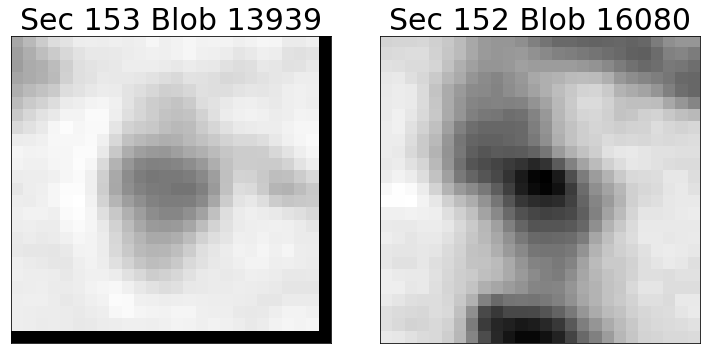

Overall Similarity:0.712092
Similarity vector:
[ 0.92682927  0.83402473  0.97582551  0.33195983  0.51496331  0.74960593
  0.75543811  0.38655424  0.93362352]


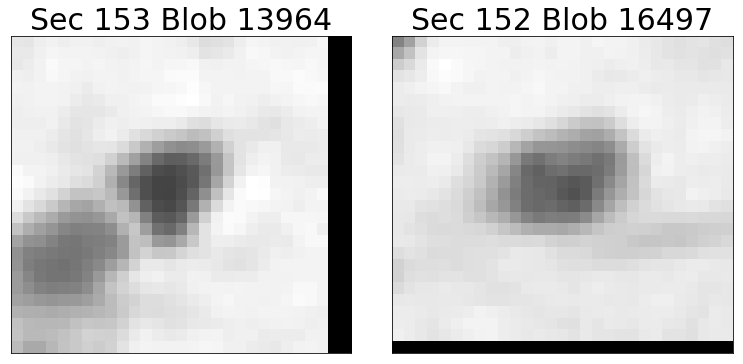

Overall Similarity:0.704615
Similarity vector:
[ 0.19379845  0.9791021   0.99205867  0.91163924  0.45048034  0.7250786
  0.72701576  0.57069188  0.7916689 ]


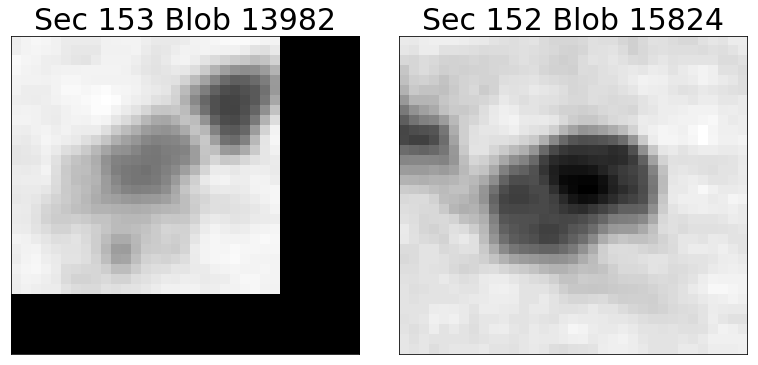

Overall Similarity:0.743754
Similarity vector:
[ 0.78125     0.30626501  0.95962628  0.78494553  0.59503479  0.95514946
  0.92640152  0.83200423  0.55311043]


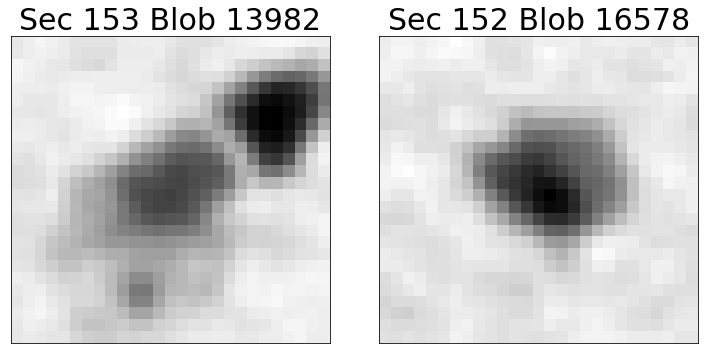

Overall Similarity:0.770190
Similarity vector:
[ 0.85714286  0.99272992  0.93218304  0.81305443  0.75630604  0.68373887
  0.59239744  0.84812323  0.45603532]


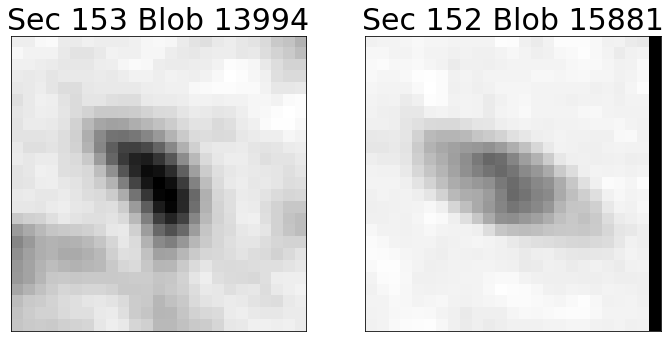

Overall Similarity:0.710372
Similarity vector:
[ 0.21212121  0.87912957  0.98291401  0.90755751  0.98741941  0.72227641
  0.976376    0.16866025  0.55689771]


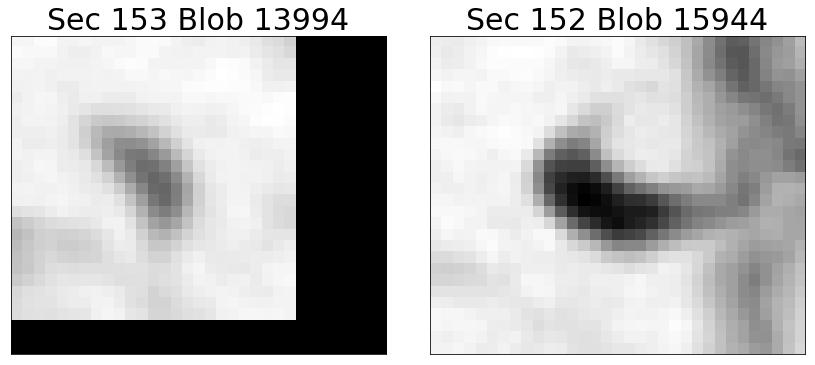

Overall Similarity:0.709916
Similarity vector:
[ 0.05283019  0.98242967  0.87552964  0.69540387  0.83518306  0.99401052
  0.71187557  0.53280724  0.70917185]


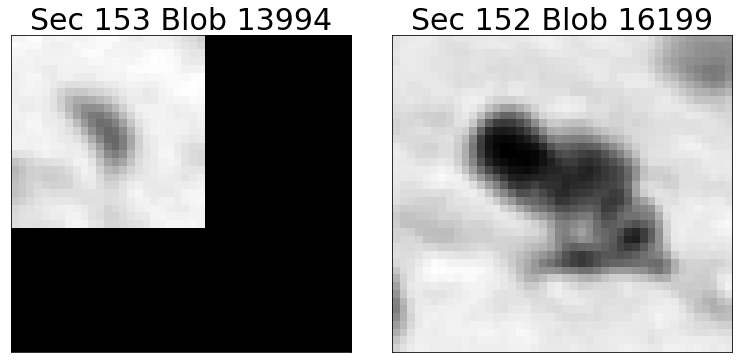

Overall Similarity:0.722667
Similarity vector:
[ 0.92        0.57465292  0.97876821  0.81227601  0.91008757  0.66595553
  0.52015289  0.48771916  0.63439105]


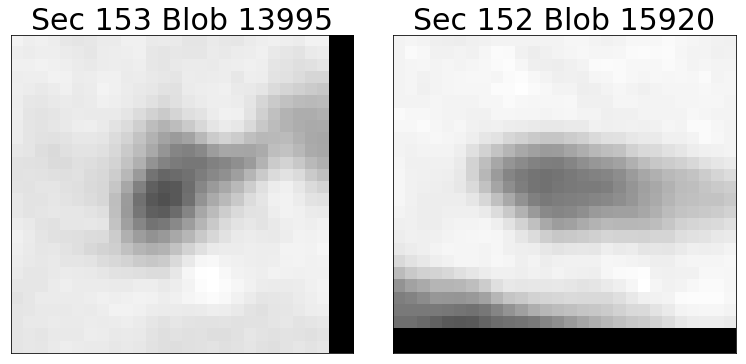

In [135]:
test_matched_pair = np.row_stack(np.where(temp_test_sim_wrt_prv_sec>0.7)).T
disp_sec = sec - 1
for disp_record_ID, disp_BID in test_matched_pair:
    disp_record_ID = disp_record_ID * 2
    temp_BID_in_sec = test_infoRecord_dic[sec][disp_record_ID][1]
    temp_BID_prv_sec = test_infoRecord_dic[sec][0][2][disp_BID]
    print('Overall Similarity:%f\nSimilarity vector:'%test_infoRecord_dic[sec][disp_record_ID][3][disp_BID])
    print(test_infoRecord_dic[sec][disp_record_ID][4][disp_BID,:])
    display_images_in_grids([fun_crop_images(im_rescale[sec],*im_blob_prop[sec][temp_BID_in_sec]['bbox'],im0max=im0max,im1max=im1max,margin=disp_margin),
                            fun_crop_images(im_rescale[disp_sec],*im_blob_prop[disp_sec][temp_BID_prv_sec]['bbox'],im0max=im0max,im1max=im1max,margin=disp_margin)],nc=2,titles=['Sec %d Blob %d'%(sec, temp_BID_in_sec),'Sec %d Blob %d'%(disp_sec, temp_BID_prv_sec)],cmap=plt.cm.gray)

## Examine one typical blob

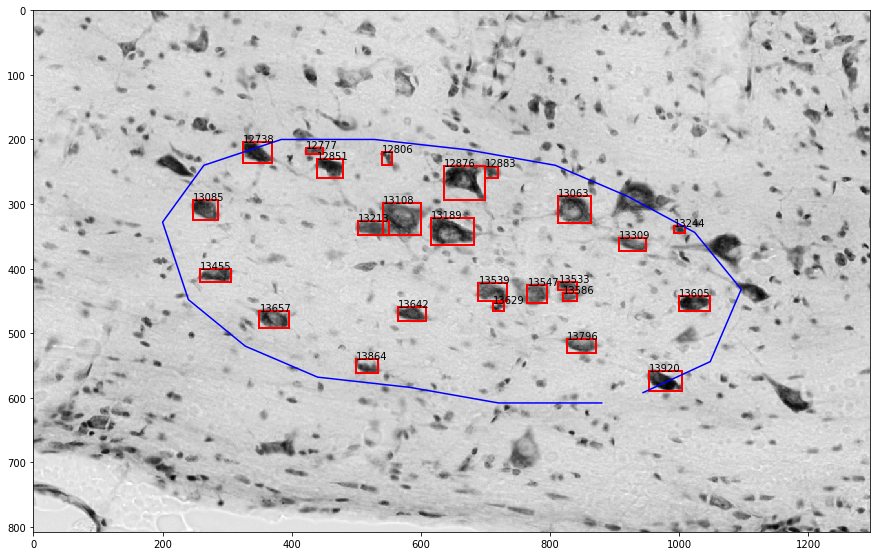

### In 7N, intuitively we think large cells like [13108, 13189, 12876, 13063] are very typical. We want to know if our algorithms can match these blobs with blobs in the 7n of the next section and what are their similarities with other blobs in 7N in the next section.Here, we take blob 13108 as an example. 

In [33]:
np.where(np.array([record[1] for record in test_infoRecord_dic[sec]])==13108)

(array([40, 41]),)

In [34]:
prop_for_comparison

['area', 'orientation', 'moments_hu']

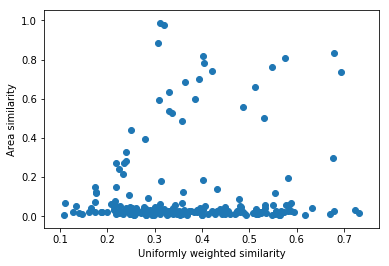

In [192]:
# Record_index 41 is the index of blob 13108 (shonw in the boxed blob figure above)

record_index = 41
plt.scatter(test_infoRecord_dic[sec][record_index][3], test_infoRecord_dic[sec][record_index][4][:,0])
plt.xlabel('Uniformly weighted similarity')
plt.ylabel('Area similarity')


### Naively thinking, the area similarity is (one of) the most important feature(s) and this feature probably has direct biological meaning. Here, I plot the scatter plot of area similarity vs the overall similarity between blob 13108 in section 153 and all the blob in 7N of section 154. The area similarity is the first component of the features similarities vector. 

### The dots at the bottom of the figure (area similarity small than 0.1) are small blobs. Though they are small, some of them are very similar with large blobs according to our current definition of similarity. Actually, the blobs with the top 2 overall similarity are small blobs. In contrast, some blobs that are very similar in size are very different in shape, when measured by hu mements. The geometric features of large blobs spans a wide spectrum. When looking at the image of large cells, we can describe some detailed similarities in grayscale texture, such as the distribution of nissl stain in the (large) cells. Is there any measurement we can use to utilized the detailed grayscale image, rather than just using the binary image? Also, for larger cells, the region properties measurement depends on the contour given by the cell-detection software, which is actually a black box. Larger cells seems to have larger chance to get some wired shape segmentation due to uneven distribution of the stain, which might effect the hu moment significantly. 

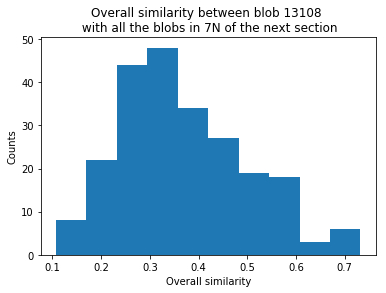

In [36]:
plt.hist(test_infoRecord_dic[sec][record_index][3]);
plt.xlabel('Overall similarity')
plt.ylabel('Counts')
plt.title('Overall similarity between blob 13108 \n with all the blobs in 7N of the next section')

### This figure shows the histogram of the overall similarity between blob 13108 in section 153 with all the blobs in 7N of section 154. 

### In the following images, first the image of blob 13108 are shown. Then, the top 20 most similar blobs in 7N section 154 of blob 13108 are ploted, with their overall similarity with blob 13108 shown in the title

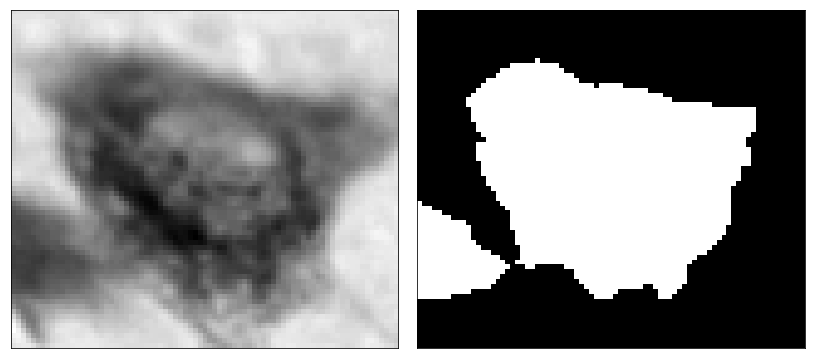

In [60]:
display_images_in_grids([fun_crop_images(im_rescale[sec],*im_blob_prop[sec][13108]['bbox'],margin=disp_margin,im0max=im0max,im1max=im1max),fun_crop_images(im_BW[sec],*im_blob_prop[sec][13108]['bbox'],margin=disp_margin,im0max=im0max,im1max=im1max)],nc=2,cmap=plt.cm.gray)

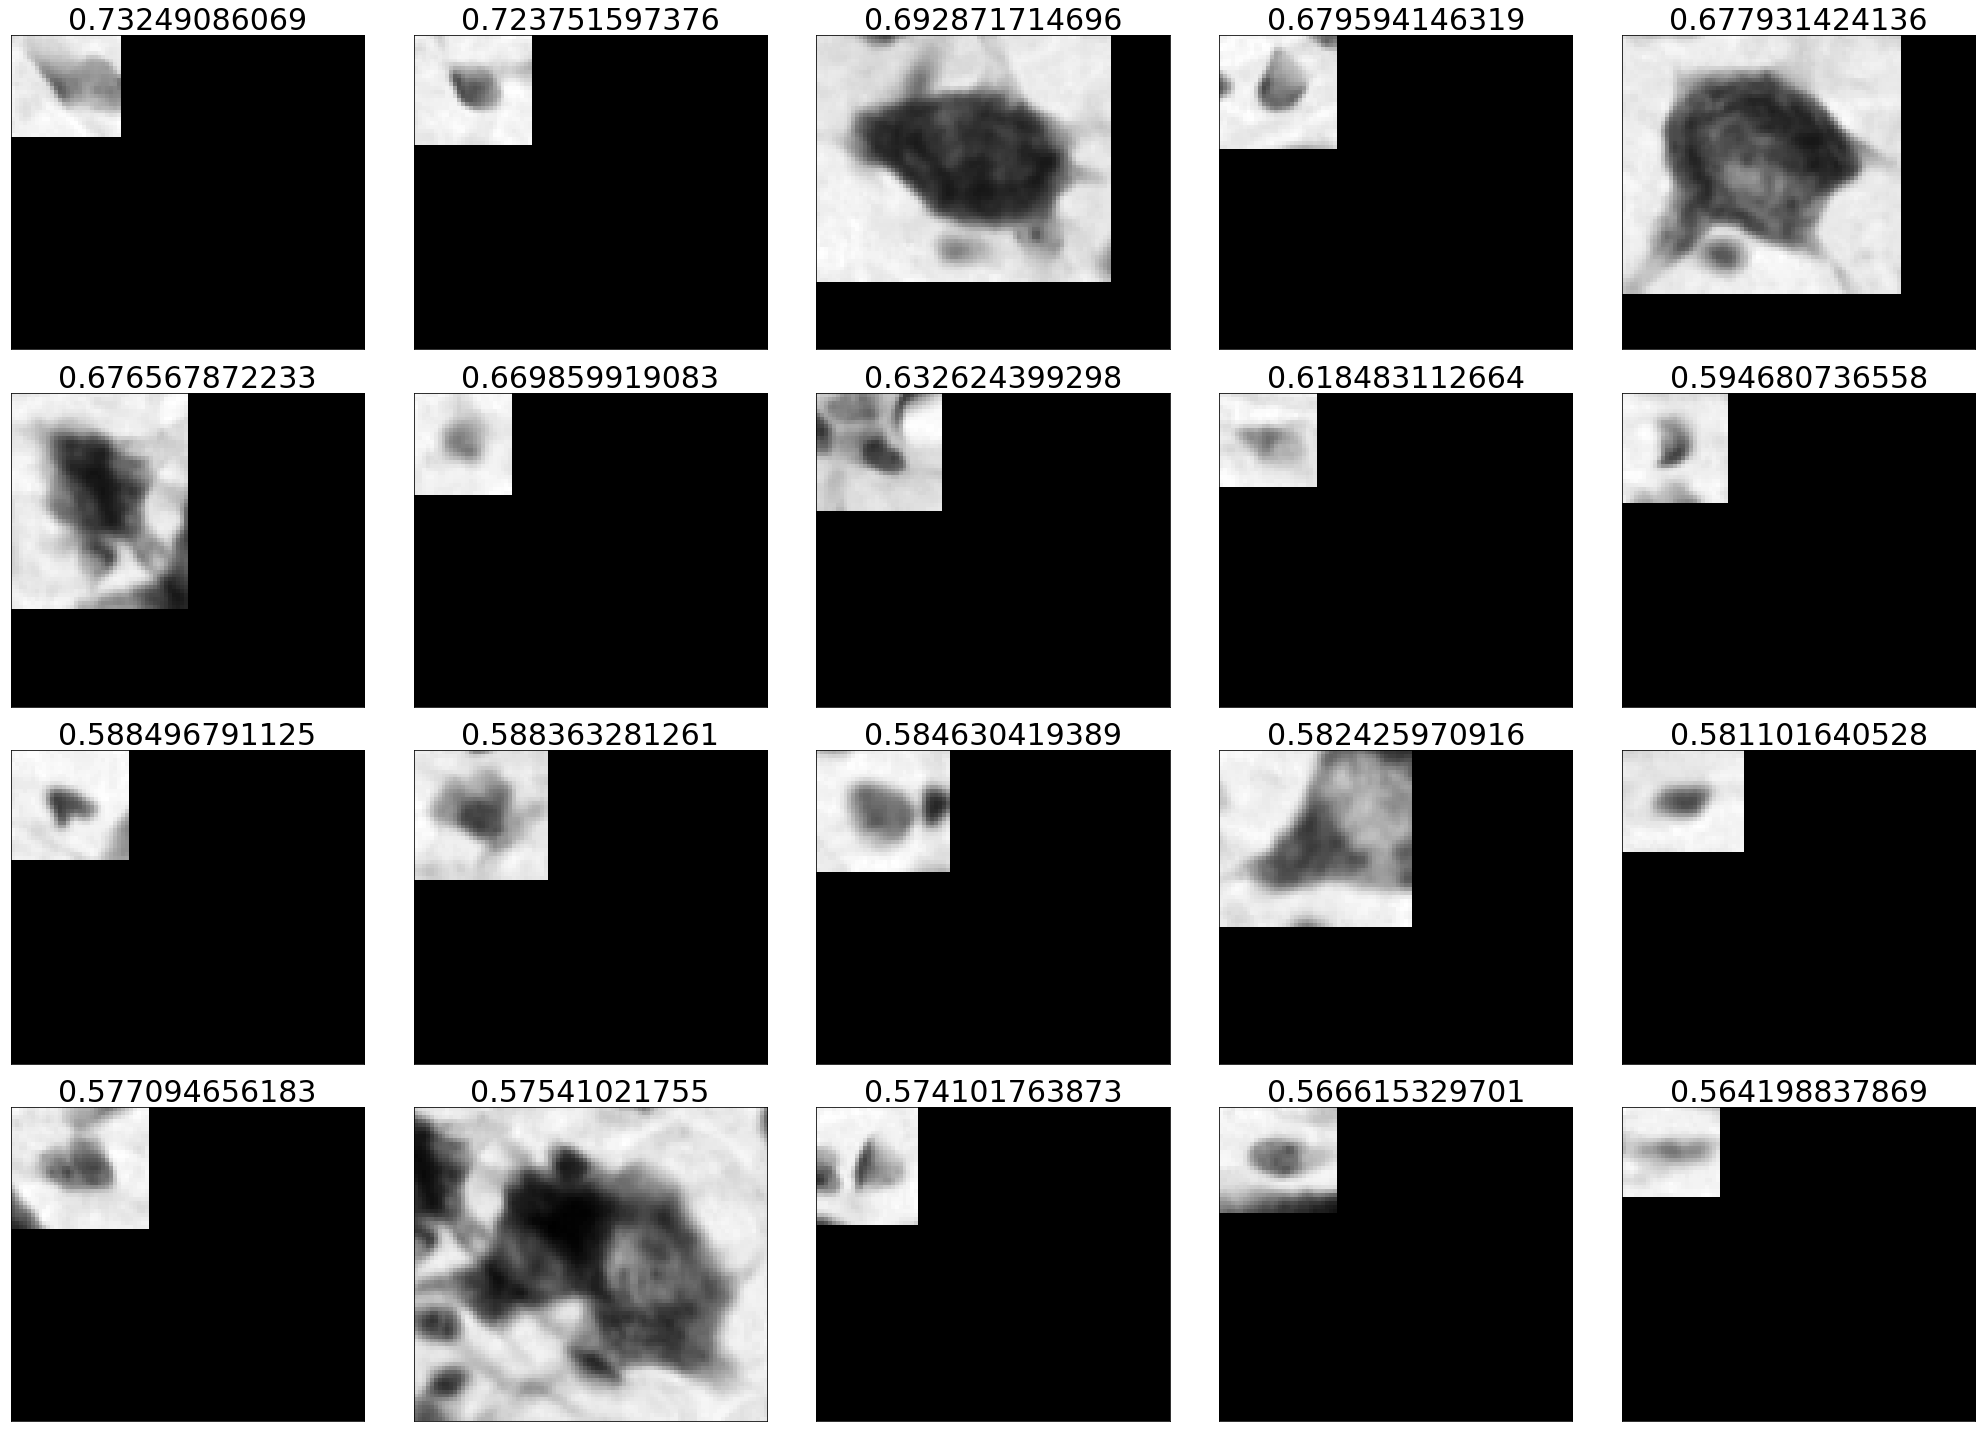

In [58]:
# Sort the compared blobID according to the overall similarity
disp_margin = 10
temp_sorted_idx = test_infoRecord_dic[sec][record_index][3].argsort()[::-1]
temp_sorted_BID = test_infoRecord_dic[sec][record_index][2][temp_sorted_idx]
temp_sorted_overall_simi = test_infoRecord_dic[sec][record_index][3][temp_sorted_idx]
display_images_in_grids([fun_crop_images(im_rescale[154], *im_blob_prop[154][tempBID]['bbox'], margin=disp_margin, im0max=im0max, im1max=im1max) for tempBID in temp_sorted_BID[0:20]],titles=temp_sorted_overall_simi[0:20],nc=5,
                        cmap=plt.cm.gray)
# test_infoRecord_dic[sec][record_index][2][temp_sorted_idxh
# Display matched blobs with overall similarity shown in the title

### If we set the threshold of overall similarty to be 0.8, few of the large blob that we think are quite typical in 7N will be classified as 'typical'. The sizes of the typical blobs are shown in the list blow, while the size of the large blob we about here are typically larger than 1000 pixels. So, if our aim is to also collect those large blobs, probably we need to lower our threshold or change our weights. 

In [59]:
[[record[1], record[2]['area']] for record in test_typicalBlobs_dic[sec]]

[[12738, 872],
 [12851, 714],
 [12882, 14],
 [12882, 14],
 [13086, 28],
 [13086, 28],
 [13146, 46],
 [13155, 11],
 [13213, 649],
 [13244, 128],
 [13455, 608],
 [13539, 682],
 [13706, 18],
 [13732, 16],
 [13920, 923],
 [13982, 25]]

# Analyzing False-matched blobs

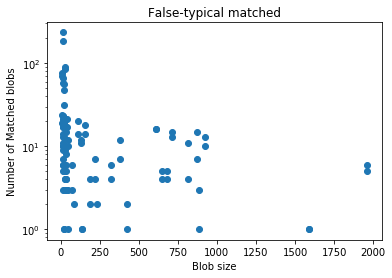

In [43]:
temp_size_vs_matched = np.array([[record[2]['area'], len(record[4])] for record in false_matchedBlobs_dic[sec]])
plt.scatter(temp_size_vs_matched[:,0],temp_size_vs_matched[:,1],)
plt.yscale('log')
plt.xlabel('Blob size')
plt.ylabel('Number of Matched blobs')
plt.title('False-typical matched')

### In this figure, we plot the number of flase-matched blobs w.r.t. the size of the blobs in 7N. The flase-matched blobs are blobs that locate out of the 7N in the neighbouring sections and have the overall similarity higher than 0.8. For small blos in 7N, we can find many (up tp ~ 10^2) similar blobs outside 7N, while for large blob we can find much less, which might due to a relatively small amount of large blobs in the whole section, and large variation in shapes when measured by hu moments. 

### The following list are the data used to plot the figure. For example, the first row [13155, 11, 19] means that for the blob ID 13155, whose area is 11 pixels, we can find 19 blobs out of (7N section 152) that have overall similarity higher than 0.8 with this blob(13155). The second row [13155, 11, 24] has the same meaning but for blobs out of (7N, section 154). Whenever there are repetitions in the blob index, the first one is for section 152 and the second one is for section 154.


In [44]:
temp_idx_size_num = np.array([[record[2]['label']-1,record[2]['area'], len(record[4])] for record in false_matchedBlobs_dic[sec]])
temp_idx_size_num[temp_idx_size_num[:,1].argsort()]

array([[13155,    11,    19],
       [13155,    11,    24],
       [13788,    11,    70],
       [13788,    11,    77],
       [13610,    13,     6],
       [13234,    13,     6],
       [13234,    13,     5],
       [13610,    13,     3],
       [13994,    14,    17],
       [13994,    14,    21],
       [12882,    14,   235],
       [12882,    14,   184],
       [13983,    16,    10],
       [13939,    16,    14],
       [13939,    16,    10],
       [13983,    16,     9],
       [13732,    16,    66],
       [13732,    16,    57],
       [12807,    17,    20],
       [13005,    17,    13],
       [13005,    17,    17],
       [12807,    17,    18],
       [13706,    18,    23],
       [13706,    18,    23],
       [13255,    19,     7],
       [13255,    19,    11],
       [13882,    21,    13],
       [12932,    21,     5],
       [12932,    21,     6],
       [13882,    21,    20],
       [13995,    23,    48],
       [13995,    23,    56],
       [13982,    25,    31],
       [13

### Example: 2 outside blobs matched with 7N 'typical' blob 13189.  
### Here, we show one of the large blobs that find external matching pairs. First, the grayscale image and binary image of blob 13189 are shown at the center. The binary image shows a blobs with complicated-shape contour given by the cell detection software. The reason for the software to give a contour like this is unclear, but I suspect this kind of contour might artifically increase the different in shape ( as therefore hu moments) between large blobs. 

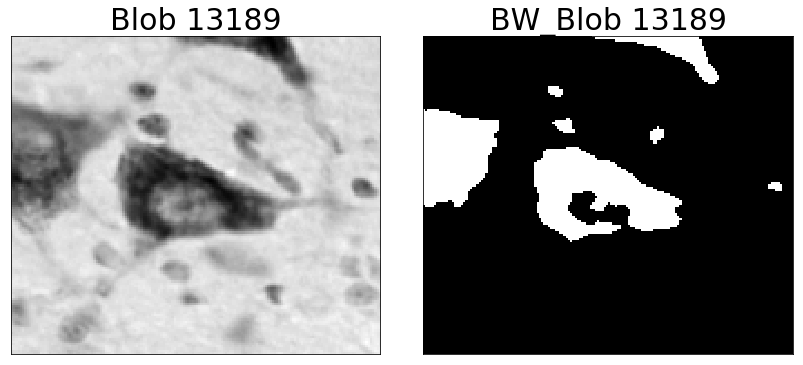

In [45]:
disp_sec = sec
disp_margin = 50
disp_blobID = 13189
display_images_in_grids([fun_crop_images(im_rescale[disp_sec],*im_blob_prop[disp_sec][disp_blobID]['bbox'],margin=disp_margin, im0max=im0max, im1max=im1max),
                        fun_crop_images(im_BW[disp_sec],*im_blob_prop[disp_sec][disp_blobID]['bbox'],margin=disp_margin, im0max=im0max, im1max=im1max)]
                        ,titles=['Blob %d'%disp_blobID,'BW_Blob %d'%disp_blobID]
                        ,
                        nc=2,cmap=plt.cm.gray)

In [46]:
np.where(np.array([record[1] for record in false_matchedBlobs_dic[sec] ]) == 13189)

(array([41, 42]),)

### Second, the external matched blobs are shown, along with the similarity vectors. The following output means that in section 153, blob 13189 is matched with blob 9397 in section 152, and the last array is the similarity vector [area, orientation, 7*hu_moments]. Inituatively, I think this blob should not be similar with the blob shown above, but this blob has highly similar hu moment and orientation with blob 13189, which is good as a  negative training set. 

### Same thing is done for another matched blob #422 in section 154. It looks more similar, but it's still quite different in size. 

In [47]:
false_matchedBlobs_dic[sec][41]

[153,
 13189,
 152,
 array([9397]),
 array([<skimage.measure._regionprops._RegionProperties object at 0x7f972567f0d0>], dtype=object),
 array([[ 0.01448363,  0.9952961 ,  0.98291133,  0.61975734,  0.889208  ,
          0.98030223,  0.89258691,  0.89162499,  0.96040553]])]

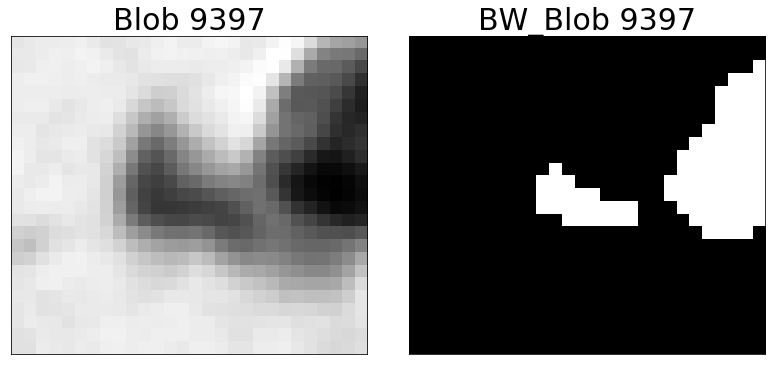

In [48]:
disp_sec = 152
disp_margin = 10
disp_blobID = 9397
display_images_in_grids([fun_crop_images(im_rescale[disp_sec],*im_blob_prop[disp_sec][disp_blobID]['bbox'],margin=disp_margin, im0max=im0max, im1max=im1max),
                        fun_crop_images(im_BW[disp_sec],*im_blob_prop[disp_sec][disp_blobID]['bbox'],margin=disp_margin, im0max=im0max, im1max=im1max)]
                        ,titles=['Blob %d'%disp_blobID,'BW_Blob %d'%disp_blobID]
                        ,
                        nc=2,cmap=plt.cm.gray)

In [49]:
false_matchedBlobs_dic[sec][42]

[153,
 13189,
 154,
 array([422]),
 array([<skimage.measure._regionprops._RegionProperties object at 0x7f9723d7fd90>], dtype=object),
 array([[ 0.20969773,  0.9640044 ,  0.98665966,  0.75474005,  0.93916275,
          0.98211956,  0.945429  ,  0.71390645,  0.79065136]])]

In [50]:
false_matchedBlobs_dic[sec][42][5][0]['area']

333

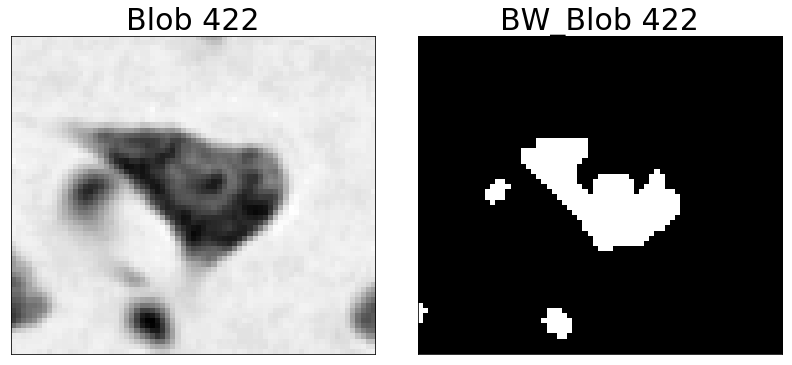

In [51]:
disp_sec = 154
disp_margin = 20
disp_blobID = 422
display_images_in_grids([fun_crop_images(im_rescale[disp_sec],*im_blob_prop[disp_sec][disp_blobID]['bbox'],margin=disp_margin, im0max=im0max, im1max=im1max),
                        fun_crop_images(im_BW[disp_sec],*im_blob_prop[disp_sec][disp_blobID]['bbox'],margin=disp_margin, im0max=im0max, im1max=im1max)]
                        ,titles=['Blob %d'%disp_blobID,'BW_Blob %d'%disp_blobID]
                        ,
                        nc=2,cmap=plt.cm.gray)

### Since this blob looks more similar, I want to know where it is in the brain stain and how does its neighbouring cells look like, which is shown in the image below. Blob 422 is near the upper right corner. 

### I am also wondering if similar blobs are detected in two disajont region of the brain stem, does it indicate any biological similarity? 

In [52]:
# Where the outside matched blob is?
im_blob_prop[154][422]['centroid']

(100.63663663663664, 669.44444444444446)

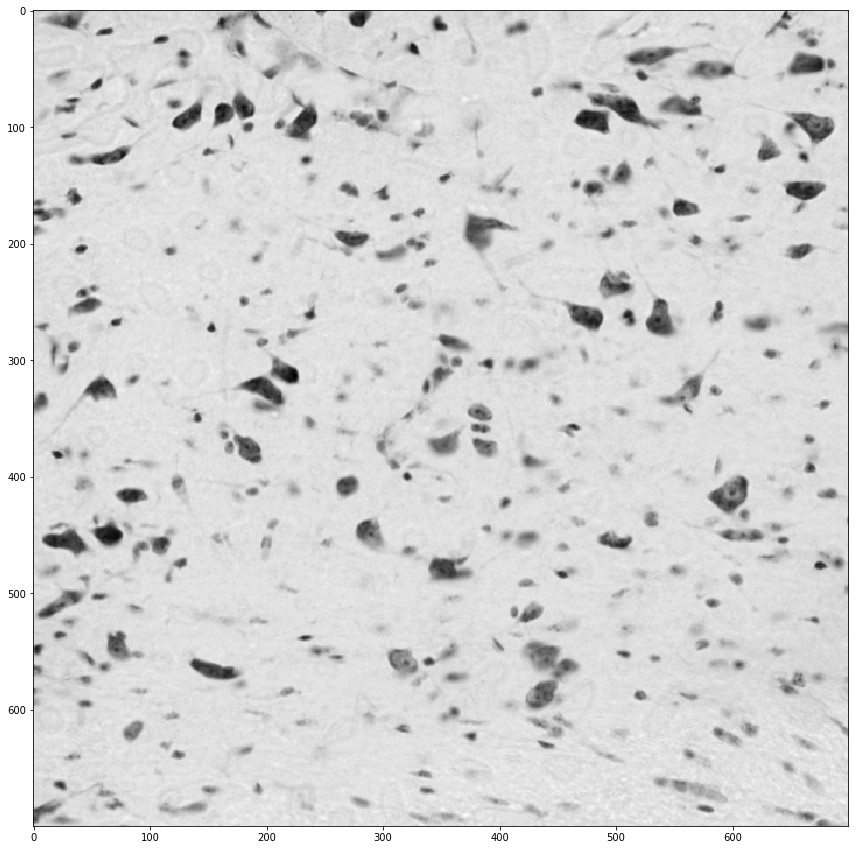

In [53]:
plt.figure(figsize=(15,15))
plt.imshow(fun_crop_images(im_rescale[154],0,0,700,700),cmap=plt.cm.gray)